In [1]:
import pandas as pd
import anndata as ad
import numpy as np
import squidpy as sq
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from anndata import AnnData
import os
import math

/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [19]:
sc.set_figure_params(figsize=(6, 6), frameon=False, dpi_save=500)
sns.set_style("white")
sns.set_theme()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [2]:
full_adata = ad.read_h5ad("/media/Lynn/data/Integrated_data/adata/run2_3_codex_znorm_xenium_norm100_log_scale_16_umap_leiden_0_7.h5ad")

In [3]:
# Replace '??' with 'Other' in xenium_annotation
full_adata.obs["xenium_annotation"] = full_adata.obs["xenium_annotation"].replace("??", "Other")
full_adata.obs["xenium_annotation"] = full_adata.obs["xenium_annotation"].replace("Eos? Enteroendocrine?", "Eos / Enteroendocrine Cells")
full_adata.obs["xenium_annotation"] = full_adata.obs["xenium_annotation"].replace("Neutrophils (M2?)", "Neutrophils / Macrophages (M2)")
full_adata.obs["xenium_annotation"] = full_adata.obs["xenium_annotation"].replace("Marophages", "Macrophages")

adata= full_adata.copy()
adata.obsm['X_umap'] = full_adata.obsm['xenium_X_umap']

/tmp/ipykernel_1186/724953946.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  full_adata.obs["xenium_annotation"] = full_adata.obs["xenium_annotation"].replace("??", "Other")
/tmp/ipykernel_1186/724953946.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  full_adata.obs["xenium_annotation"] = full_adata.obs["xenium_annotation"].replace("Eos? Enteroendocrine?", "Eos / Enteroendocrine Cells")
/tmp/ipykernel_1186/724953946.py:4: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace

## With Xenium annotation

### Xenium

#### Clustering

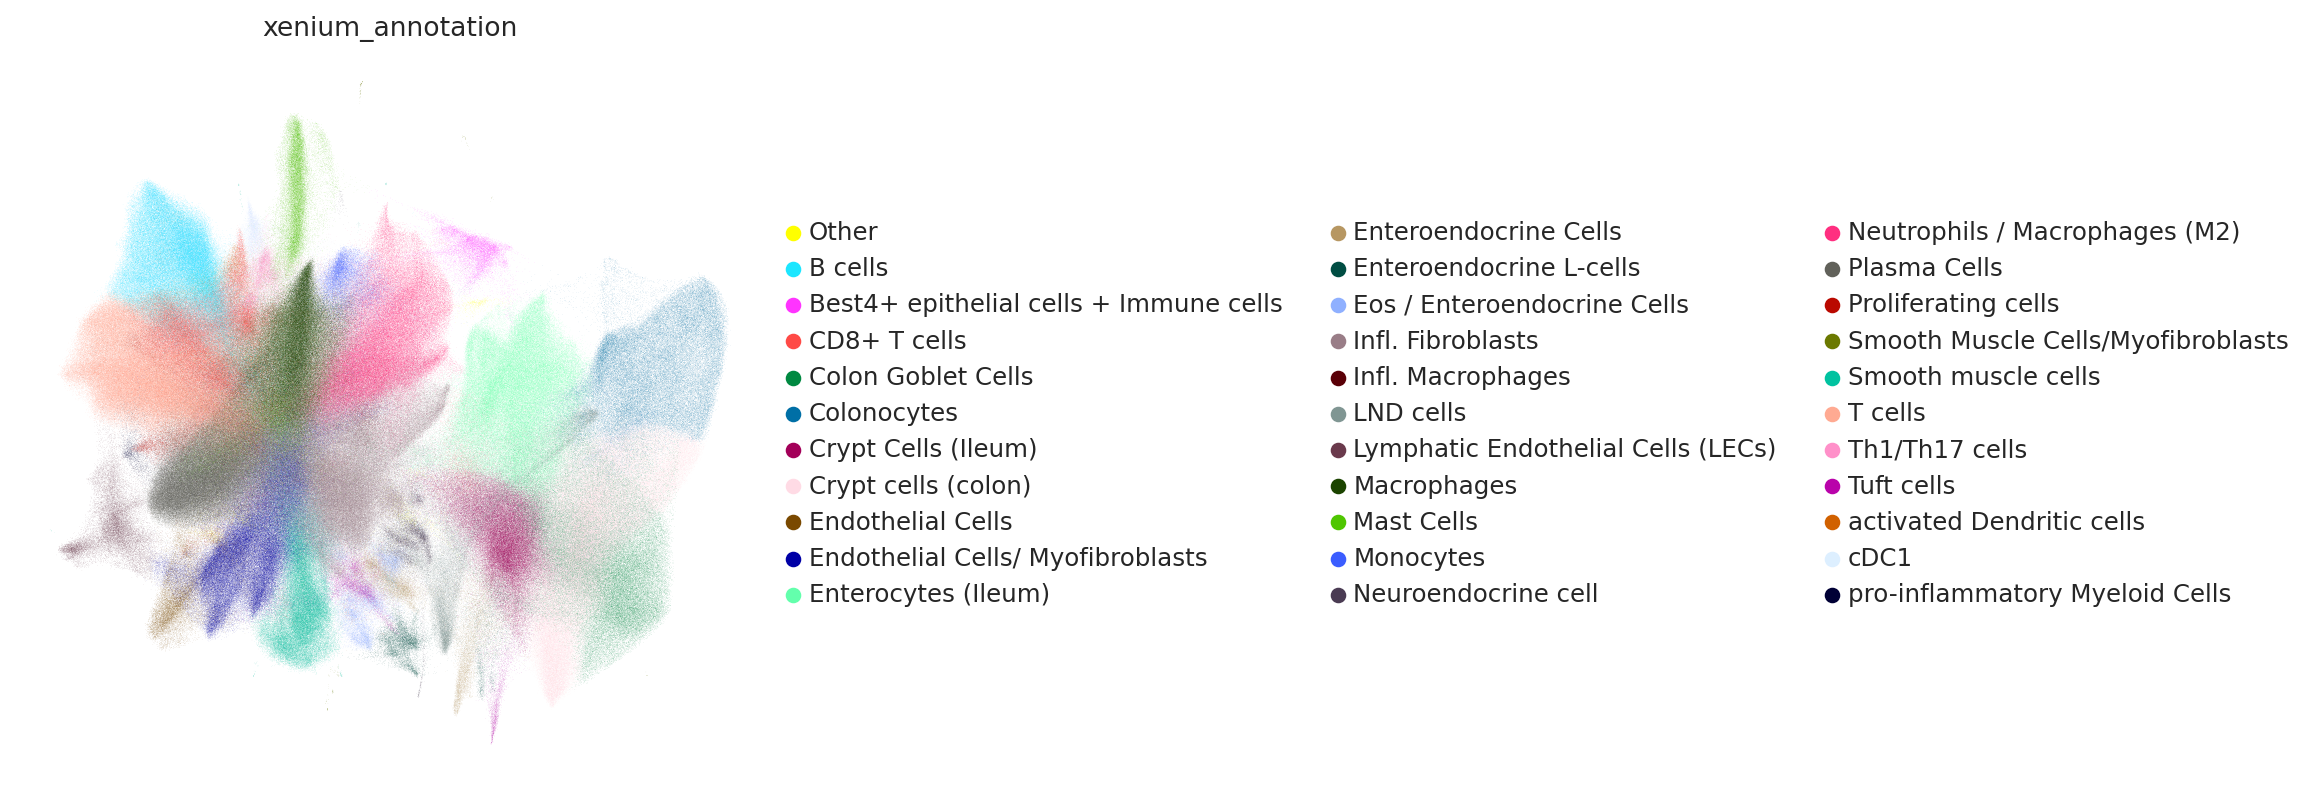

In [99]:
sc.pl.umap(
    adata,
    color="xenium_annotation",
    wspace=0.4,
    save="xenium_annotation.png"
)

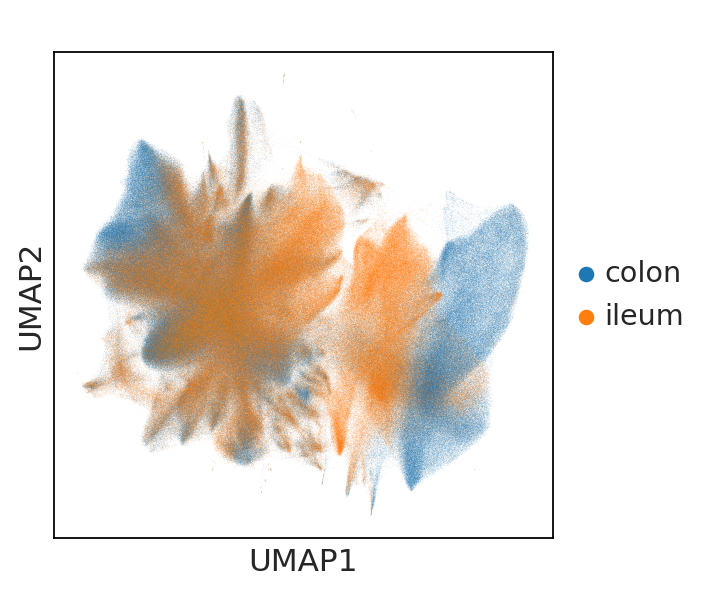

In [30]:
sc.pl.umap(
    adata,
    color="tissue",
    wspace=0.4,
    title = " ",
    save="_run2+3_xenium_by_tissue_highres.png"
)

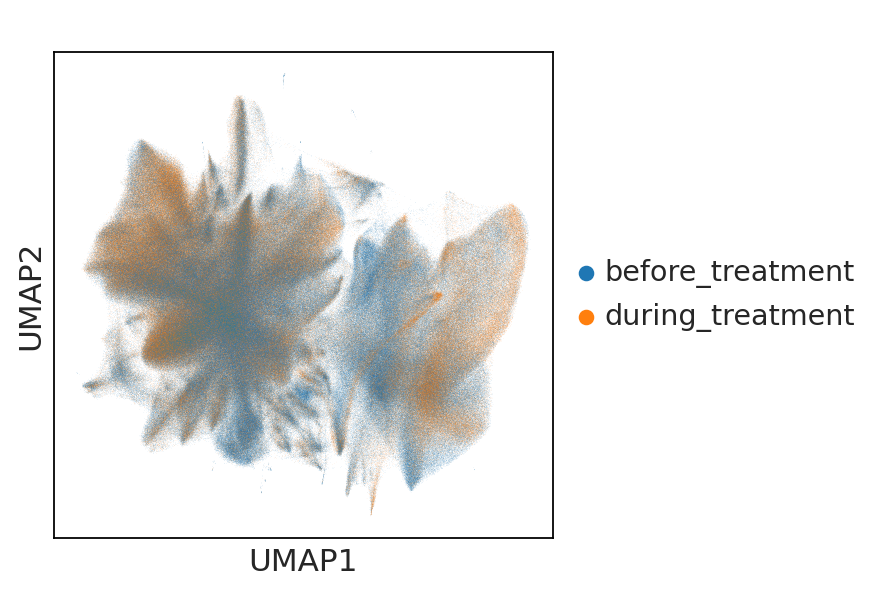

In [31]:
sc.pl.umap(
    adata,
    color="time_point",
    wspace=0.4,
    title = " ",
    save="_run2+3_xenium_by_timepoint_highres.png"
)

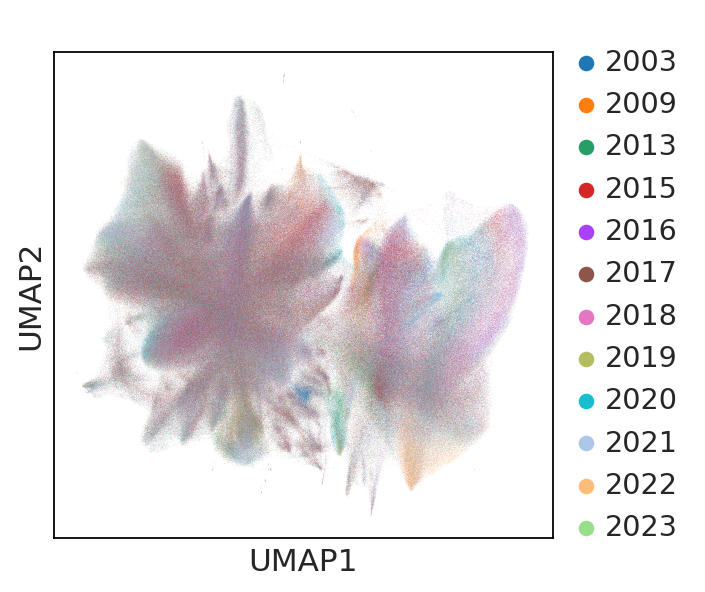

In [32]:
adata.obs["year"] = adata.obs["year"].astype(str) 
sc.pl.umap(
    adata,
    color="year",
    wspace=0.4,
    title = " ",
    save="_run2+3_xenium_by_year_highres.png"
)

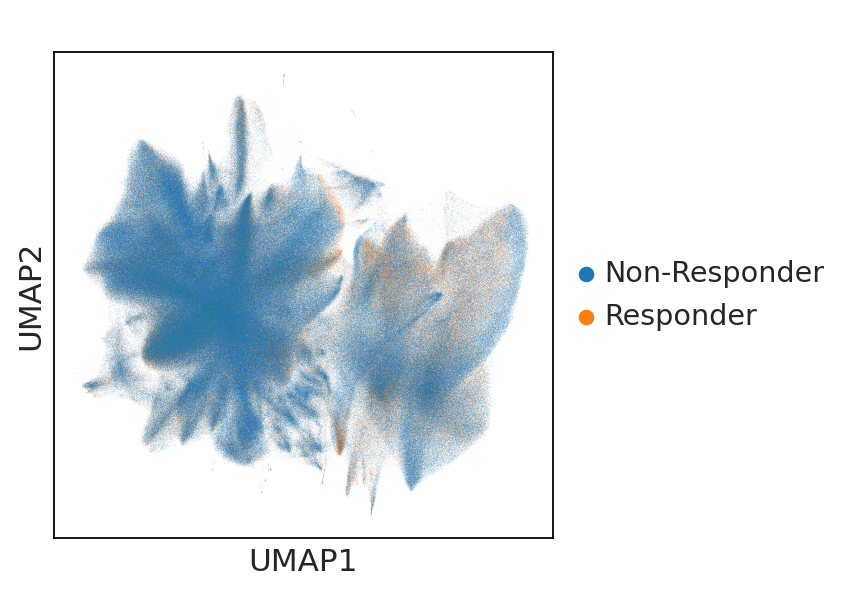

In [34]:
adata.obs['response_group'] = np.where(
    adata.obs['patient_ID'].str.endswith('_NR'), 'Non-Responder',
    np.where(
        adata.obs['patient_ID'].str.endswith('_R'), 'Responder', 'Unknown'
    )
)
sc.pl.umap(
    adata,
    color="response_group",
    wspace=0.4,
    title = " ",
    save="_run2+3_xenium_by_response_group_highres.png"
)

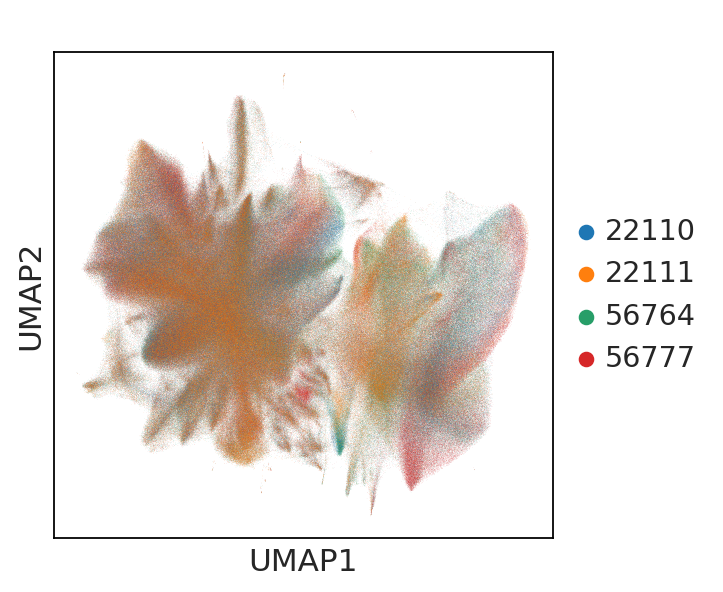

In [35]:
adata.obs["slide_ID"] = adata.obs["slide_ID"].astype(str) 
sc.pl.umap(
    adata,
    color="slide_ID",
    wspace=0.4,
    title = " ",
    save="_run2+3_xenium_by_slide_highres.png"
)

#### QC table

In [43]:
adata2=ad.read_h5ad("/media/Lisa/For_Lynn/run2_3_raw_data.h5ad")

/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [67]:
sc.pp.filter_cells(adata2, min_counts=5)

In [69]:
sc.pp.filter_genes(adata2, min_cells=2)

In [70]:
adata2

AnnData object with n_obs × n_vars = 2205208 × 422
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'core_ID', 'slide_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_1_genes', 'pct_counts_in_top_5_genes', 'pct_counts_in_top_10_genes', 'n_counts', 'tissue', 'time_point', 'patient_ID', 'year', 'block_ID', 'cohort', 'run_ID', 'response_group', 'n_transcripts', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'X_pca', 'X_umap', 'spatial'
    layers: 'counts'

In [71]:
# Use raw counts layer if needed
if 'xenium_counts' in adata2.layers:
    counts = adata2.layers['xenium_counts']
else:
    counts = adata2.X

# Calculate total transcripts and genes per cell
adata2.obs['n_transcripts'] = counts.sum(axis=1).A1 if hasattr(counts, 'A1') else counts.sum(axis=1)
adata2.obs['n_genes'] = (counts > 0).sum(axis=1).A1 if hasattr(counts, 'A1') else (counts > 0).sum(axis=1)

# Grouping variables
grouping_vars = ['slide_ID', 'core_ID', 'patient_ID', 'time_point', 'response_group', 'year', 'tissue']

summary_stats = {}

for var in grouping_vars:
    grouped = adata2.obs.groupby(var)
    stats = grouped.agg(
        total_cells=('n_transcripts', 'count'),
        total_transcripts=('n_transcripts', 'sum'),
        avg_transcripts_per_cell=('n_transcripts', 'median'),
        avg_genes_per_cell=('n_genes', 'median'),
    )
    
    df = grouped.agg(
        total_cells=('total_counts', 'count'),
        total_transcripts=('total_counts', 'sum'),
        control_probe_counts=('control_probe_counts', 'sum'),
        control_codeword_counts=('control_codeword_counts', 'sum')
    )

    df['negative_dna_pct'] = 100 * df['control_probe_counts'] / df['total_transcripts']
    df['negative_decoding_pct'] = 100 * df['control_codeword_counts'] / df['total_transcripts']
    
    summary_stats[var] = stats
    
    summary_stats[var] = summary_stats[var].join(df[['negative_dna_pct', 'negative_decoding_pct']])
    
metrics = [
    'total_cells',
    'total_transcripts',
    'avg_transcripts_per_cell',
    'avg_genes_per_cell',
    'negative_dna_pct',
    'negative_decoding_pct'
]
'''
for var, df in summary_stats.items():
    df_copy = df.copy()
    df_copy['condition'] = df_copy.index  # the group names

    for metric in metrics:
        plt.figure(figsize=(8, 5))
        
        # Boxplot
        sns.boxplot(y=metric, data=df_copy, width=0.3, color='lightgray', showfliers=False)
        
        # Overlay dots for each condition
        sns.stripplot(
            y=metric, 
            x=[0]*len(df_copy),  # all dots at the same x location
            data=df_copy, 
            size=8, 
            color='blue'
        )
        
        # Annotate each dot with the condition name
        for i, cond in enumerate(df_copy['condition']):
            plt.text(
                x=0.05,  # slightly to the right of the dot
                y=df_copy.loc[cond, metric],
                s=cond,
                fontsize=9,
                verticalalignment='center'
            )
        
        plt.title(f'{metric} per {var}')
        plt.xticks([])  # hide x-axis since all dots are at the same position
        plt.ylabel(metric)
        plt.tight_layout()
        plt.show()
'''


/tmp/ipykernel_1186/1473322366.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata2.obs.groupby(var)
/tmp/ipykernel_1186/1473322366.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata2.obs.groupby(var)
/tmp/ipykernel_1186/1473322366.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata2.obs.groupby(var)
/tmp/ipykernel_1186/1473322366.py:17: FutureWarning: The default of ob

"\nfor var, df in summary_stats.items():\n    df_copy = df.copy()\n    df_copy['condition'] = df_copy.index  # the group names\n\n    for metric in metrics:\n        plt.figure(figsize=(8, 5))\n\n        # Boxplot\n        sns.boxplot(y=metric, data=df_copy, width=0.3, color='lightgray', showfliers=False)\n\n        # Overlay dots for each condition\n        sns.stripplot(\n            y=metric, \n            x=[0]*len(df_copy),  # all dots at the same x location\n            data=df_copy, \n            size=8, \n            color='blue'\n        )\n\n        # Annotate each dot with the condition name\n        for i, cond in enumerate(df_copy['condition']):\n            plt.text(\n                x=0.05,  # slightly to the right of the dot\n                y=df_copy.loc[cond, metric],\n                s=cond,\n                fontsize=9,\n                verticalalignment='center'\n            )\n\n        plt.title(f'{metric} per {var}')\n        plt.xticks([])  # hide x-axis since a

In [72]:
# Select the most relevant QC metrics
relevant_metrics = [
    'avg_transcripts_per_cell',
    'avg_genes_per_cell',
    'negative_dna_pct',
    'negative_decoding_pct'
]

summary_list = []

for var, df in summary_stats.items():
    df_copy = df[relevant_metrics].copy()
    
    # Compute mean and standard deviation across conditions for each metric
    row = {'metadata': var}
    for metric in relevant_metrics:
        row[f'{metric}_mean'] = df_copy[metric].mean()
        row[f'{metric}_std'] = df_copy[metric].std()
    summary_list.append(row)

# Create summary table
summary_table = pd.DataFrame(summary_list)

summary_table


metadata  avg_transcripts_per_cell_mean  \
0        slide_ID                      31.500000   
1         core_ID                      32.593750   
2      patient_ID                      41.220589   
3      time_point                      32.500000   
4  response_group                      36.000000   
5            year                      37.000000   
6          tissue                      34.000000   

   avg_transcripts_per_cell_std  avg_genes_per_cell_mean  \
0                      5.446712                21.500000   
1                      9.300917                21.843750   
2                     19.098307                25.235294   
3                      6.363961                22.000000   
4                      9.899495                23.500000   
5                     18.988033                24.750000   
6                     12.727922                22.500000   

   avg_genes_per_cell_std  negative_dna_pct_mean  negative_dna_pct_std  \
0                2.886751               0.038823              0.006527   
1                5.382824               0.038602              0.007154   
2                9.135541               0.036220              0.017098   
3                4.242641               0.038237              0.001805   
4                4.949747               0.035731              0.008681   
5               11.647278               0.042726              0.013466   
6                7.778175               0.038019              0.000370   

   negative_decoding_pct_mean  negative_decoding_pct_std  
0                    0.002502                   0.001192  
1                    0.002602                   0.001047  
2                    0.002594                   0.001867  
3                    0.002716                   0.000338  
4                    0.003160                   0.001529  
5                    0.002232                   0.001139  
6                    0.002719                   0.001343

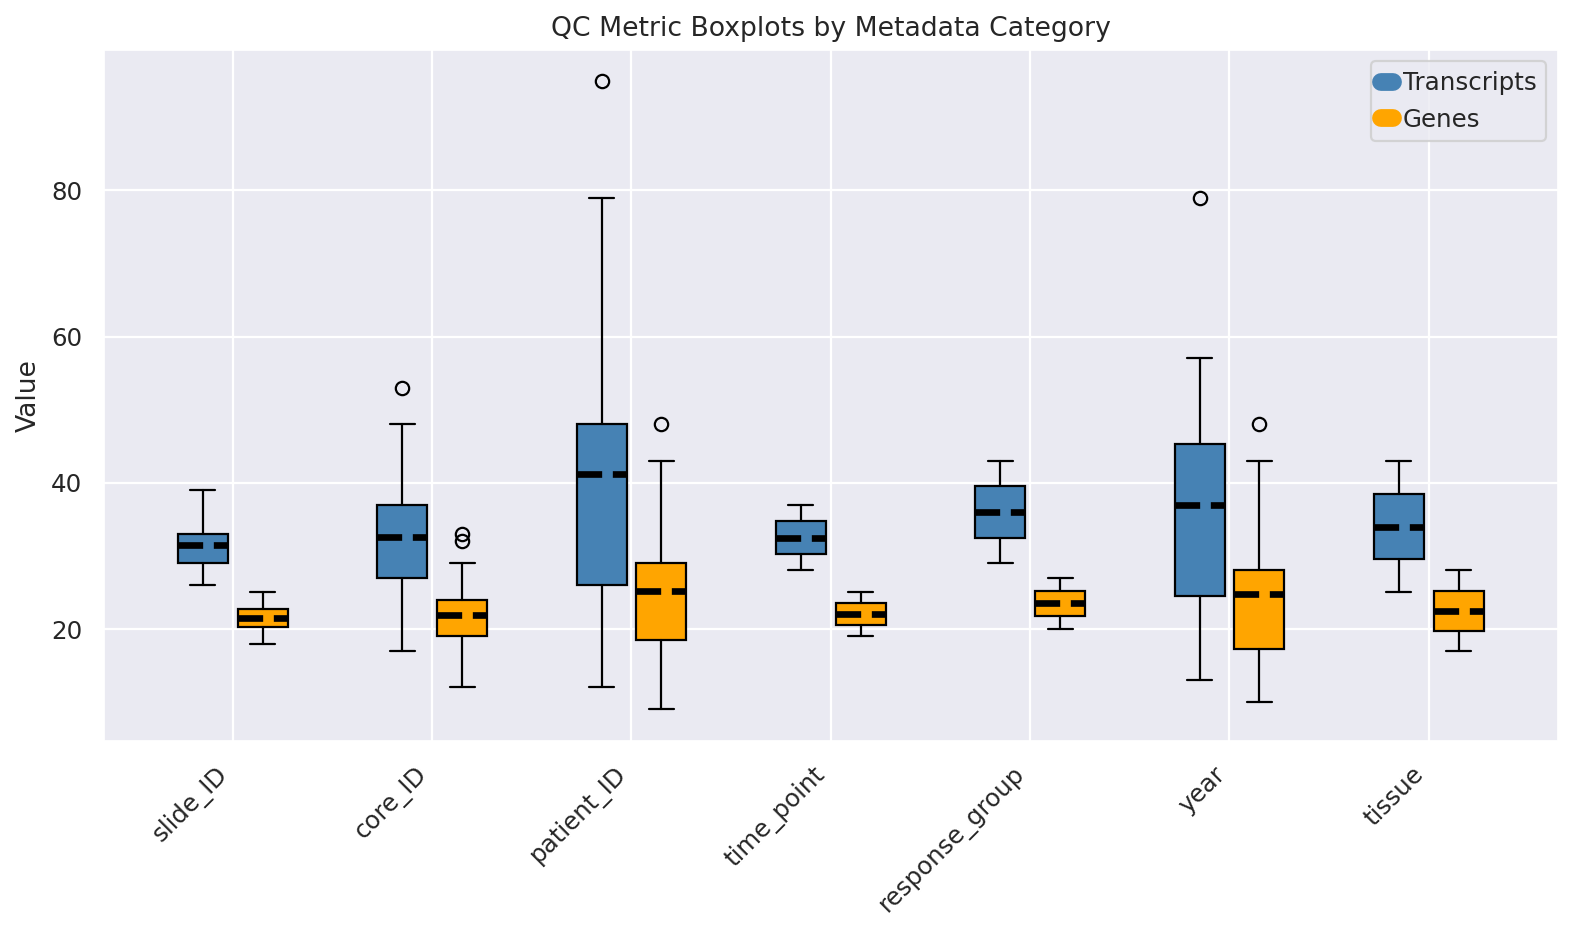

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Convert summary_stats → long format
plot_rows = []
for meta, df in summary_stats.items():
    for metric in ['avg_transcripts_per_cell', 'avg_genes_per_cell']:
        for val in df[metric]:
            plot_rows.append({
                'metadata': meta,
                'metric': metric,
                'value': val
            })

plot_df = pd.DataFrame(plot_rows)

# Unique metadata categories
metas = plot_df['metadata'].unique()
n = len(metas)

# Colors for each metric
metric_colors = {
    'avg_transcripts_per_cell': 'steelblue',
    'avg_genes_per_cell': 'orange'
}

# Prepare figure
plt.figure(figsize=(10, 6))

positions = []
boxes = []
labels = []

# width between groups
group_width = 0.6
# offset of two boxes within each group
offset = 0.15

for i, meta in enumerate(metas):
    center = i + 1  # x location for this group
    meta_df = plot_df[plot_df['metadata'] == meta]

    # transcripts
    t_vals = meta_df[meta_df['metric'] == 'avg_transcripts_per_cell']['value']
    t_pos = center - offset
    box = plt.boxplot(t_vals, positions=[t_pos], widths=0.25, patch_artist=True, showmeans=True, meanline=True, meanprops=dict(color='black', linewidth=3), medianprops=dict(visible=False))
    for patch in box['boxes']:
        patch.set_facecolor(metric_colors['avg_transcripts_per_cell'])
    boxes.append(box['boxes'][0])

    # genes
    g_vals = meta_df[meta_df['metric'] == 'avg_genes_per_cell']['value']
    g_pos = center + offset
    box = plt.boxplot(g_vals, positions=[g_pos], widths=0.25, patch_artist=True, showmeans=True, meanline=True, meanprops=dict(color='black', linewidth=3), medianprops=dict(visible=False))
    for patch in box['boxes']:
        patch.set_facecolor(metric_colors['avg_genes_per_cell'])
    boxes.append(box['boxes'][0])

# X-axis ticks
plt.xticks(range(1, n+1), metas, rotation=45, ha='right')

# Legend
plt.legend(
    handles=[
        plt.Line2D([0], [0], color=metric_colors['avg_transcripts_per_cell'], lw=8),
        plt.Line2D([0], [0], color=metric_colors['avg_genes_per_cell'], lw=8)
    ],
    labels=['Transcripts', 'Genes']
)

plt.ylabel("Value")
plt.title("QC Metric Boxplots by Metadata Category")
plt.tight_layout()
plt.show()


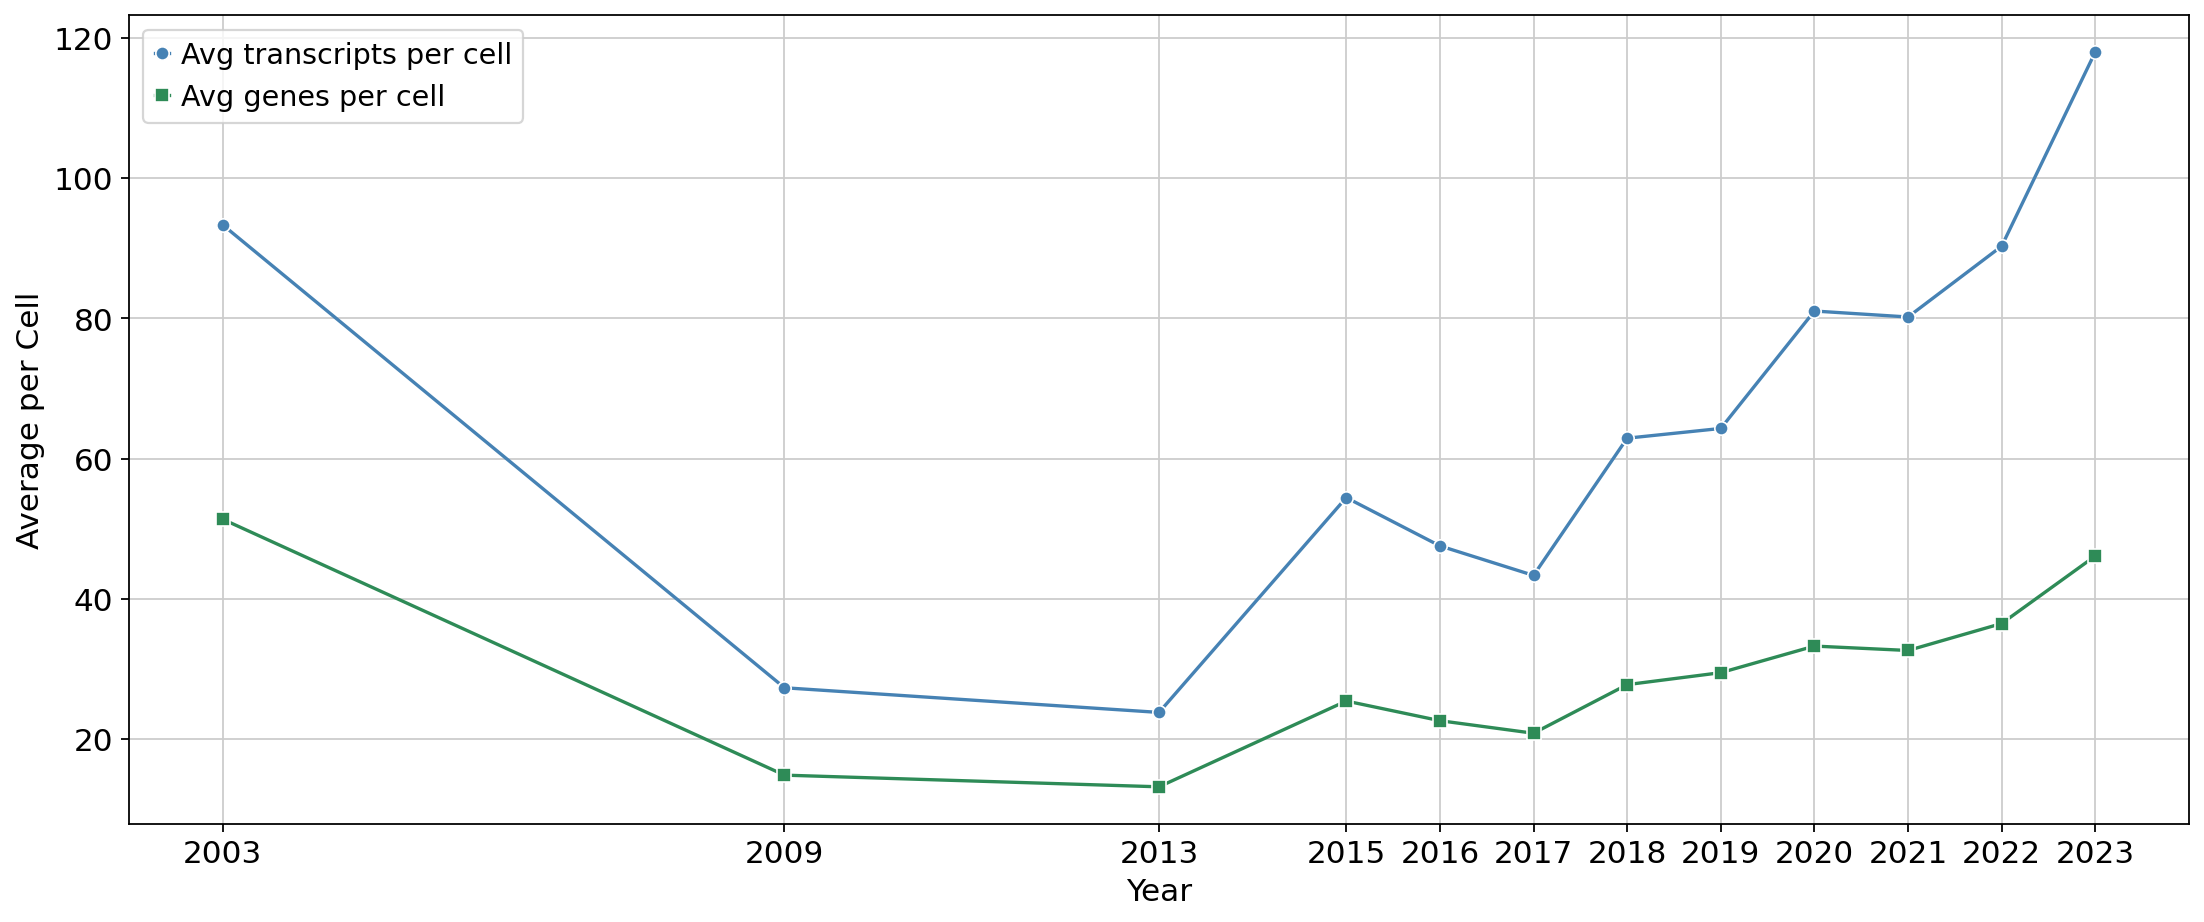

In [22]:
# Extract the summary for 'year'
df_year = summary_stats['year'].copy()
df_year = df_year.reset_index()  # move 'year' from index to a column
df_year['year'] = df_year['year'].astype(int)  # ensure numeric
df_year = df_year.sort_values('year')

plt.figure(figsize=(14, 6))  # wider figure for better readability

# Line plots for avg transcripts and genes per cell
sns.lineplot(x='year', y='avg_transcripts_per_cell', data=df_year, marker='o', label='Avg transcripts per cell', color='steelblue')
sns.lineplot(x='year', y='avg_genes_per_cell', data=df_year, marker='s', label='Avg genes per cell', color='seagreen')

plt.xlabel('Year')
plt.ylabel('Average per Cell')
plt.title('')
plt.xticks(df_year['year'])  # ensure all years are shown
plt.legend()
plt.tight_layout()

# Save figure in high resolution
plt.savefig('figures/xenium_avg_transcripts_genes_by_year.png', dpi=500)

plt.show()

### CODEX

In [87]:
codex_channels = ['DAPI', 'FoxP3', 'aSMA', 'CD4', 'CD8', 'CD31', 
                 'CD11c', 'IFNG', 'Pan-Cytokeratin', 'CD68', 'CD20', 
                 'CD66b', 'TNFa', 'CD45RO', 'CD14', 'CD11b', 'Vimentin', 
                 'CD163', 'PDGFRA', 'CD45', 'CCR7', 'IL10', 'CD38', 'CD69', 
                 'Podoplanin', 'PNAd', 'ECP', 'MPO', 'MIP-3', 'CD16', 'CXCL13'
]

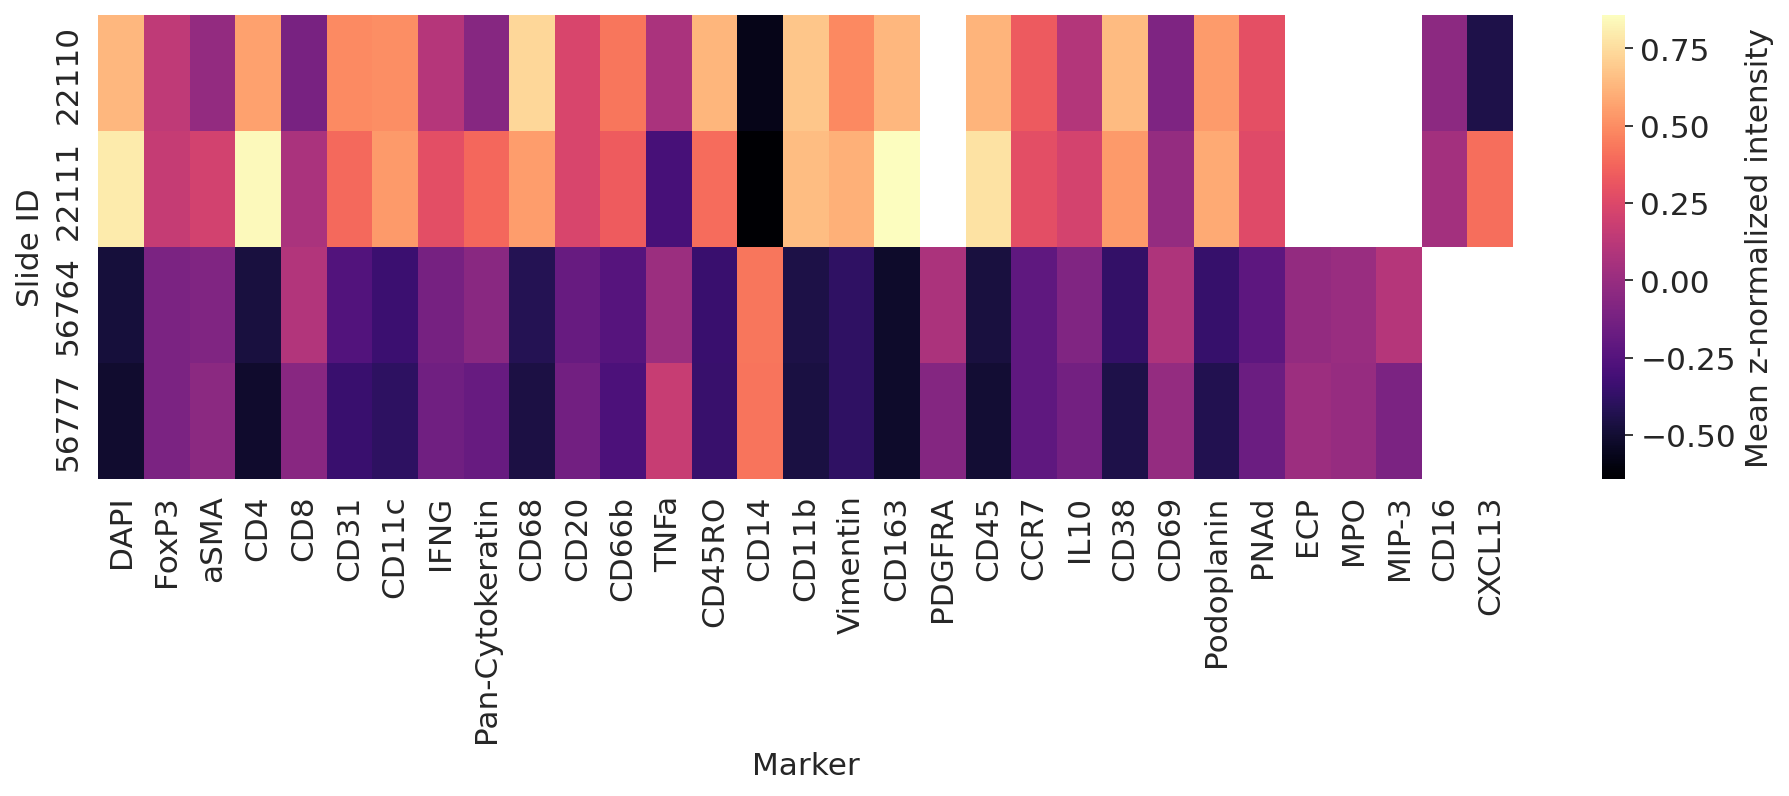

In [22]:
# Optional: set output directory
output_dir = "./figures/QC_Run2+3/codex_intensities_per_slide"
os.makedirs(output_dir, exist_ok=True)

# 1. Create DataFrame with z-normalized channels only
df = full_adata.obs[codex_channels + ['slide_ID']].copy()

# 2. Compute mean z-normalized intensity per slide
intensity_mean_z = df.groupby('slide_ID')[codex_channels].mean()

# 3. Plot Mean Z-normalized Intensity (slides on y-axis, markers on x-axis)
plt.figure(figsize=(12, 5.2))
sns.heatmap(intensity_mean_z, cmap='magma', cbar_kws={'label': 'Mean z-normalized intensity'})
plt.xlabel("Marker")
plt.ylabel("Slide ID")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "mean_znorm_intensity_per_slide_highres.png"), dpi=500)
plt.show()

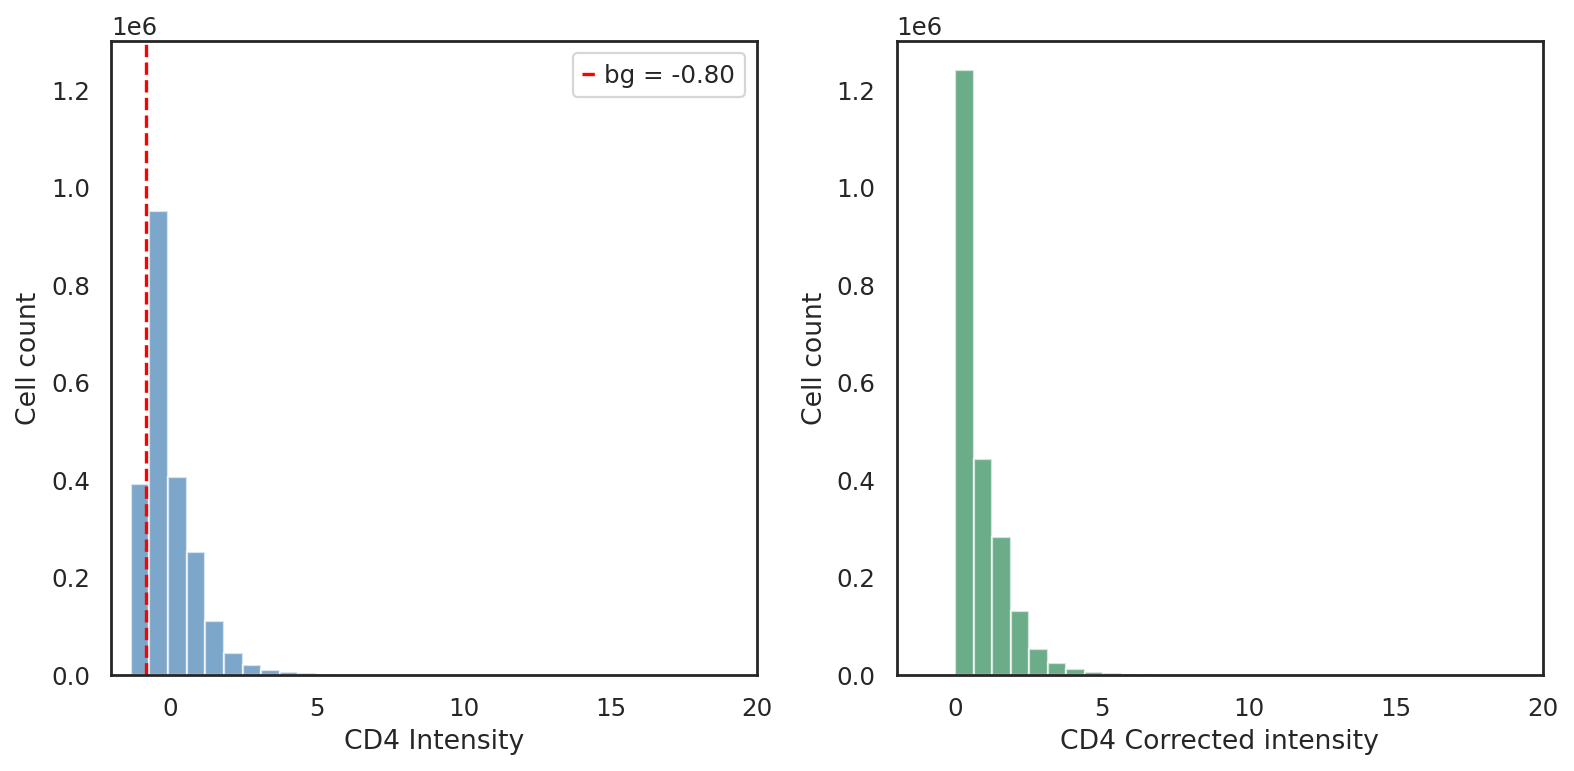

In [113]:
# Extract raw CD4 intensities from .obs
cd4_raw = adata.obs["CD4"].values

# Compute background as 10th percentile
bg = np.percentile(cd4_raw, 10)

# Apply background subtraction
cd4_corrected = np.clip(cd4_raw - bg, 0, None)

# Store corrected values in a new column
adata.obs["CD4_CDX_corrected"] = cd4_corrected

# Plot before/after
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(cd4_raw, bins=100, color="steelblue", alpha=0.7)
plt.axvline(bg, color="red", linestyle="--", label=f"bg = {bg:.2f}")
plt.xlabel("CD4 Intensity"); plt.ylabel("Cell count")
plt.legend()
plt.xlim(-2, 20) 
plt.ylim(0, 1300000)

plt.subplot(1,2,2)
plt.hist(cd4_corrected, bins=100, color="seagreen", alpha=0.7)
plt.xlabel("CD4 Corrected intensity"); plt.ylabel("Cell count")
plt.xlim(-2, 20) 
plt.ylim(0, 1300000)

plt.tight_layout()
plt.savefig('figures/barplot_cd4_bg_correction_10_percent.png', dpi=400)
plt.show()


In [7]:
adata.obs.rename(columns={'CD4': 'CD4_CDX'}, inplace=True)
# Extract raw CD4 intensities from .obs
cd4_raw = adata.obs["CD4_CDX"].values

# Compute background as 10th percentile
bg = np.percentile(cd4_raw, 10)

# Apply background subtraction
cd4_corrected = np.clip(cd4_raw - bg, 0, None)

# Store corrected values in a new column
adata.obs["CD4_CDX_corrected"] = cd4_corrected

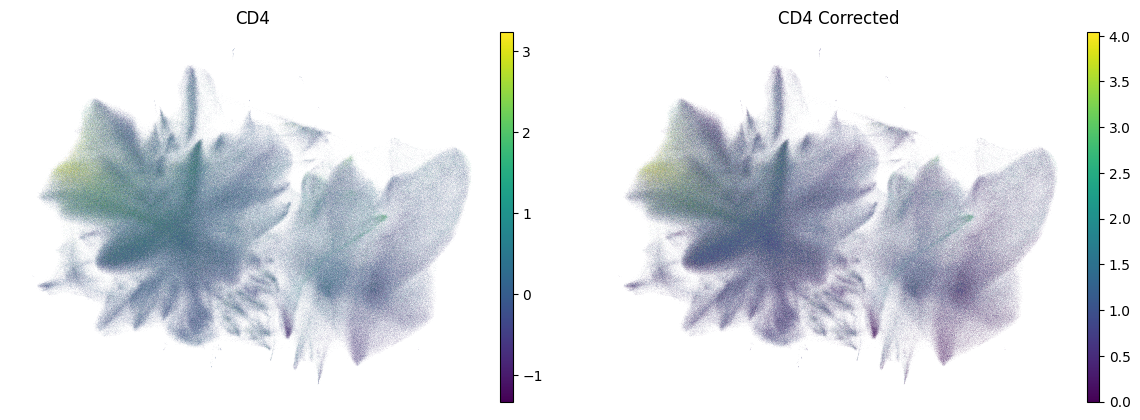

In [9]:
sc.pl.embedding(
    adata,
    basis="xenium_X_umap",
    color=['CD4_CDX', 'CD4_CDX_corrected'],
    frameon=False,
    vmax='p99',
    wspace=0.1,
    ncols = 2,
    title = ['CD4', 'CD4 Corrected'],
    save = '_CD4_before_after_correction_10_percent.png'
)

In [ ]:
import scanpy as sc

# Make a clean categorical column
adata.obs['tcell_highlight'] = adata.obs['xenium_annotation'].apply(
    lambda x: 'T cells' if x == 'T cells' else 'Other'
).astype('category')


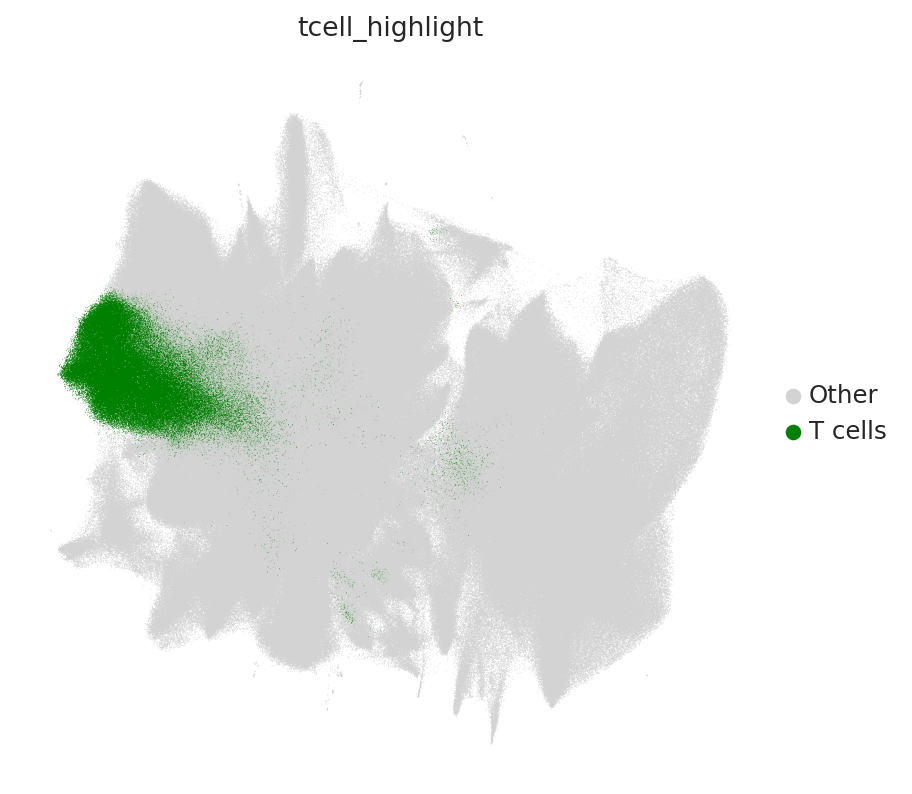

In [30]:
# Choose colors: first is 'Other', second is 'T cells'
palette = ['lightgrey', 'green']

sc.pl.embedding(
    adata,
    basis="xenium_X_umap",
    color='tcell_highlight',
    palette=palette,
    legend_loc='right margin',
    size=0.5,
    save='_xenium_tcells.png'
)

In [94]:
#--------------------------------------------------
# 1. Define protein → gene mapping (from your table)
#--------------------------------------------------
protein_to_gene = {
    "FoxP3": "FOXP3",
    "aSMA": "ACTA2",
    "CD4": "CD4",
    "CD8": "CD8A",      # use CD8A (or average CD8A/B if desired)
    "CD11c": "ITGAX",
    "IFNG": "IFNG",
    "CD68": "CD68",
    "CD20": "MS4A1",
    "TNFa": "TNF",
    "CD14": "CD14",
    "CD11b": "ITGAM",
    "CD163": "CD163",
    "IL10": "IL10",
    "CD45": "PTPRC",
    "CCR7": "CCR7",
    "PDGFRA": "PDGFRA",
    "Podoplanin": "PDPN",
    "MIP-3": "CCL20",
}
print(f"Matched {len(protein_to_gene)} protein–transcript pairs.")

#--------------------------------------------------
# 2. Select relevant columns from your AnnData
#--------------------------------------------------
protein_cols = list(protein_to_gene.keys())
transcript_cols = [g for g in protein_to_gene.values() if g in adata.var_names]

#--------------------------------------------------
# 3. Extract protein and transcript data
#--------------------------------------------------
# a) Protein data from adata.obs
protein_expr = adata.obs[protein_cols].copy()
protein_expr.columns = [f"{m}_CDX" for m in protein_cols]  # add suffix to avoid duplicates

# b) Transcript data from adata.X
transcript_expr = pd.DataFrame(
    adata[:, transcript_cols].X.toarray() if hasattr(adata.X, "toarray") else adata[:, transcript_cols].X,
    columns=transcript_cols,
    index=adata.obs_names
)

#--------------------------------------------------
# 4. Combine into a single dataframe
#--------------------------------------------------
combined_df = pd.concat([protein_expr, transcript_expr], axis=1)

#--------------------------------------------------
# 5. Order columns so each protein is followed by its transcript
#--------------------------------------------------
ordered_vars = []
for prot, gene in protein_to_gene.items():
    prot_name = f"{prot}_CDX"
    if prot_name in combined_df.columns:
        ordered_vars.append(prot_name)
    if gene in combined_df.columns:
        ordered_vars.append(gene)

# Restrict to existing ordered columns
ordered_vars = [v for v in ordered_vars if v in combined_df.columns]
combined_df = combined_df[ordered_vars]

#--------------------------------------------------
# 6. Create a temporary AnnData for plotting
#--------------------------------------------------
combined_adata = ad.AnnData(
    X=combined_df.values,
    obs=pd.DataFrame({"cluster": adata.obs['xenium_annotation'].values}, index=adata.obs_names),
    var=pd.DataFrame(index=combined_df.columns)
)

Matched 18 protein–transcript pairs.


/tmp/ipykernel_21646/2009333059.py:29: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



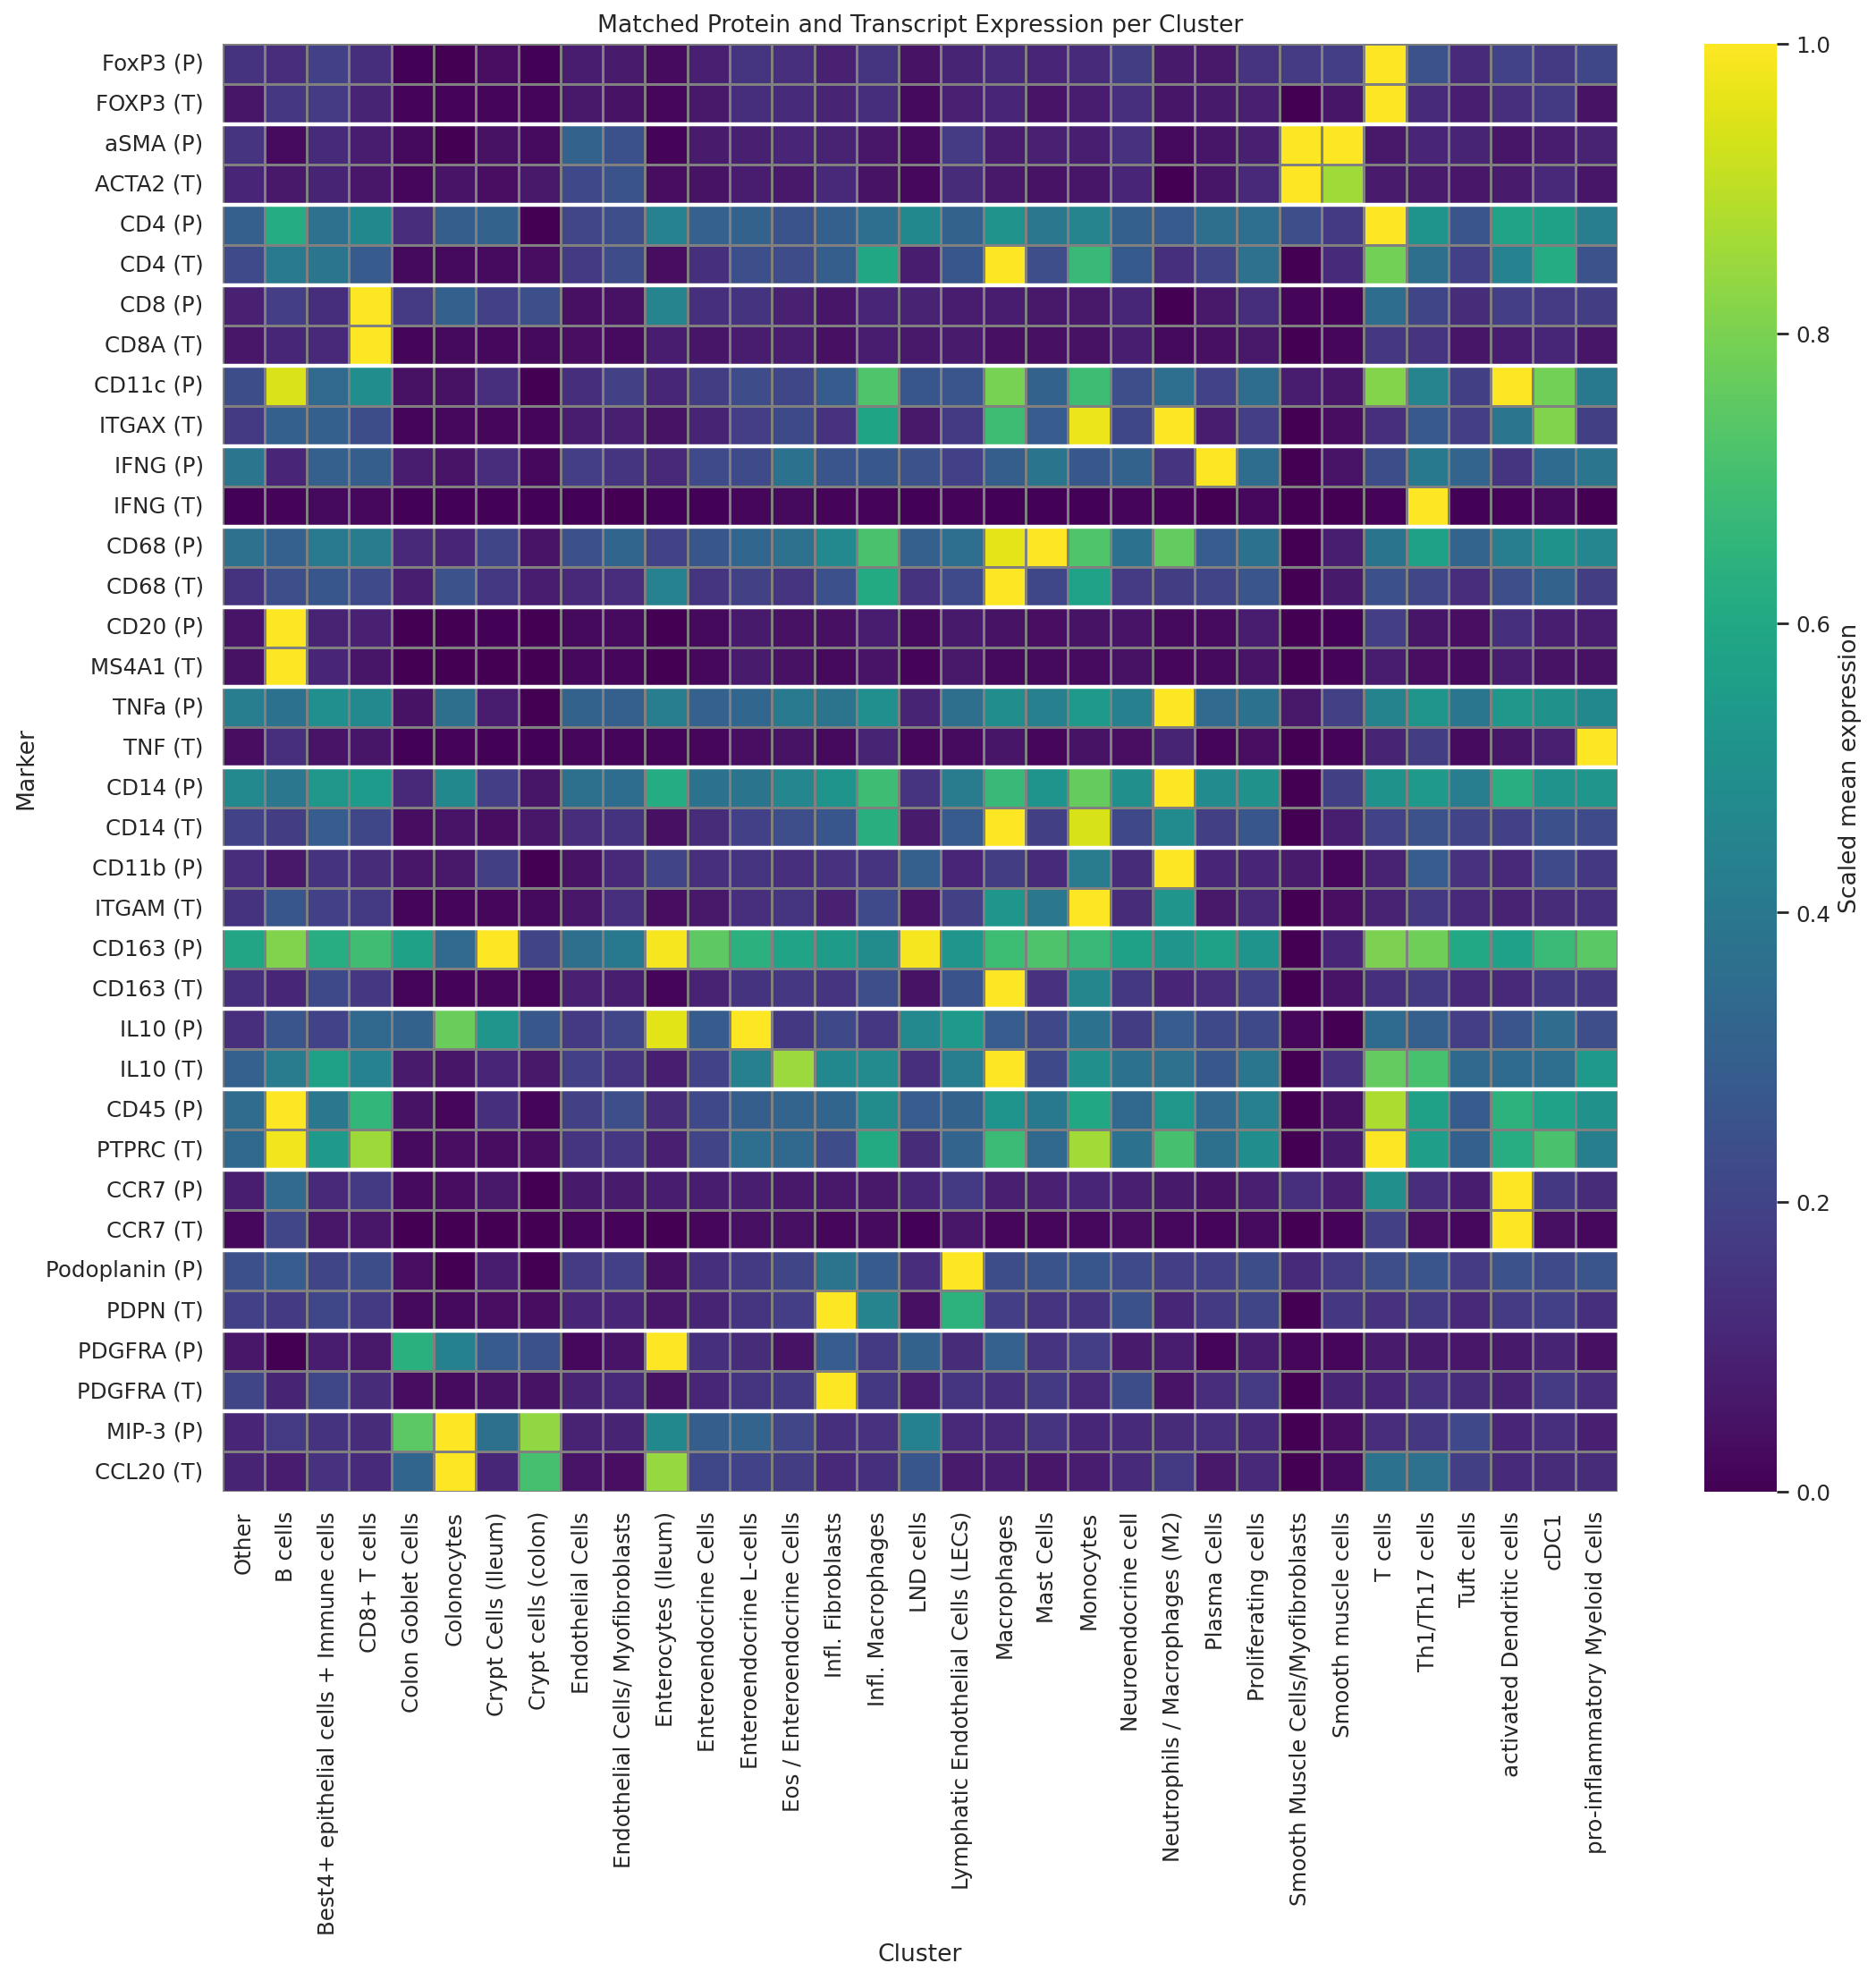

In [95]:
# 1. Matched protein–transcript pairs
pairs = [
    ("FoxP3_CDX", "FOXP3"),
    ("aSMA_CDX", "ACTA2"),
    ("CD4_CDX", "CD4"),
    ("CD8_CDX", "CD8A"),
    ("CD11c_CDX", "ITGAX"),
    ("IFNG_CDX", "IFNG"),
    ("CD68_CDX", "CD68"),
    ("CD20_CDX", "MS4A1"),
    ("TNFa_CDX", "TNF"),
    ("CD14_CDX", "CD14"),
    ("CD11b_CDX", "ITGAM"),
    ("CD163_CDX", "CD163"),
    ("IL10_CDX", "IL10"),
    ("CD45_CDX", "PTPRC"),
    ("CCR7_CDX", "CCR7"),
    ("Podoplanin_CDX", "PDPN"),
    ("PDGFRA_CDX", "PDGFRA"),
    ("MIP-3_CDX", "CCL20"),
]

# Keep only pairs present in your data
pairs = [(p, r) for p, r in pairs if p in combined_adata.var_names and r in combined_adata.var_names]

# 2. Mean expression per cluster
cluster_key = "cluster"
df = pd.DataFrame(combined_adata.X, columns=combined_adata.var_names, index=combined_adata.obs[cluster_key])
mean_expr = df.groupby(level=0).mean()

# 3. Order columns according to pairs
ordered_cols = [x for pair in pairs for x in pair]
mean_expr = mean_expr[ordered_cols]

# Scale 0–1 per marker
scaled = (mean_expr - mean_expr.min()) / (mean_expr.max() - mean_expr.min())

# 4. Plot heatmap
plt.figure(figsize=(14, 14))
ax = sns.heatmap(
    scaled.T,
    cmap="viridis",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Scaled mean expression"},
)

# 5. Add separators **between each protein–RNA pair**
for i in range(1, len(pairs)):
    ax.hlines(y=i*2, xmin=0, xmax=scaled.shape[0], colors="white", linewidth=2)

# 6. Add y-axis labels (protein + RNA)
yticklabels = []
for p, r in pairs:
    yticklabels.append(p.replace("_CDX", "") + " (P)")
    yticklabels.append(r + " (T)")

yticks = np.arange(len(ordered_cols)) + 0.5
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, rotation=0)

# Labels and title
plt.ylabel("Marker")
plt.xlabel("Cluster")
plt.title("Matched Protein and Transcript Expression per Cluster")

plt.tight_layout()
plt.savefig("heatmap_protein_transcript_pairs_separated_highres.png", dpi=500)
plt.show()


/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.



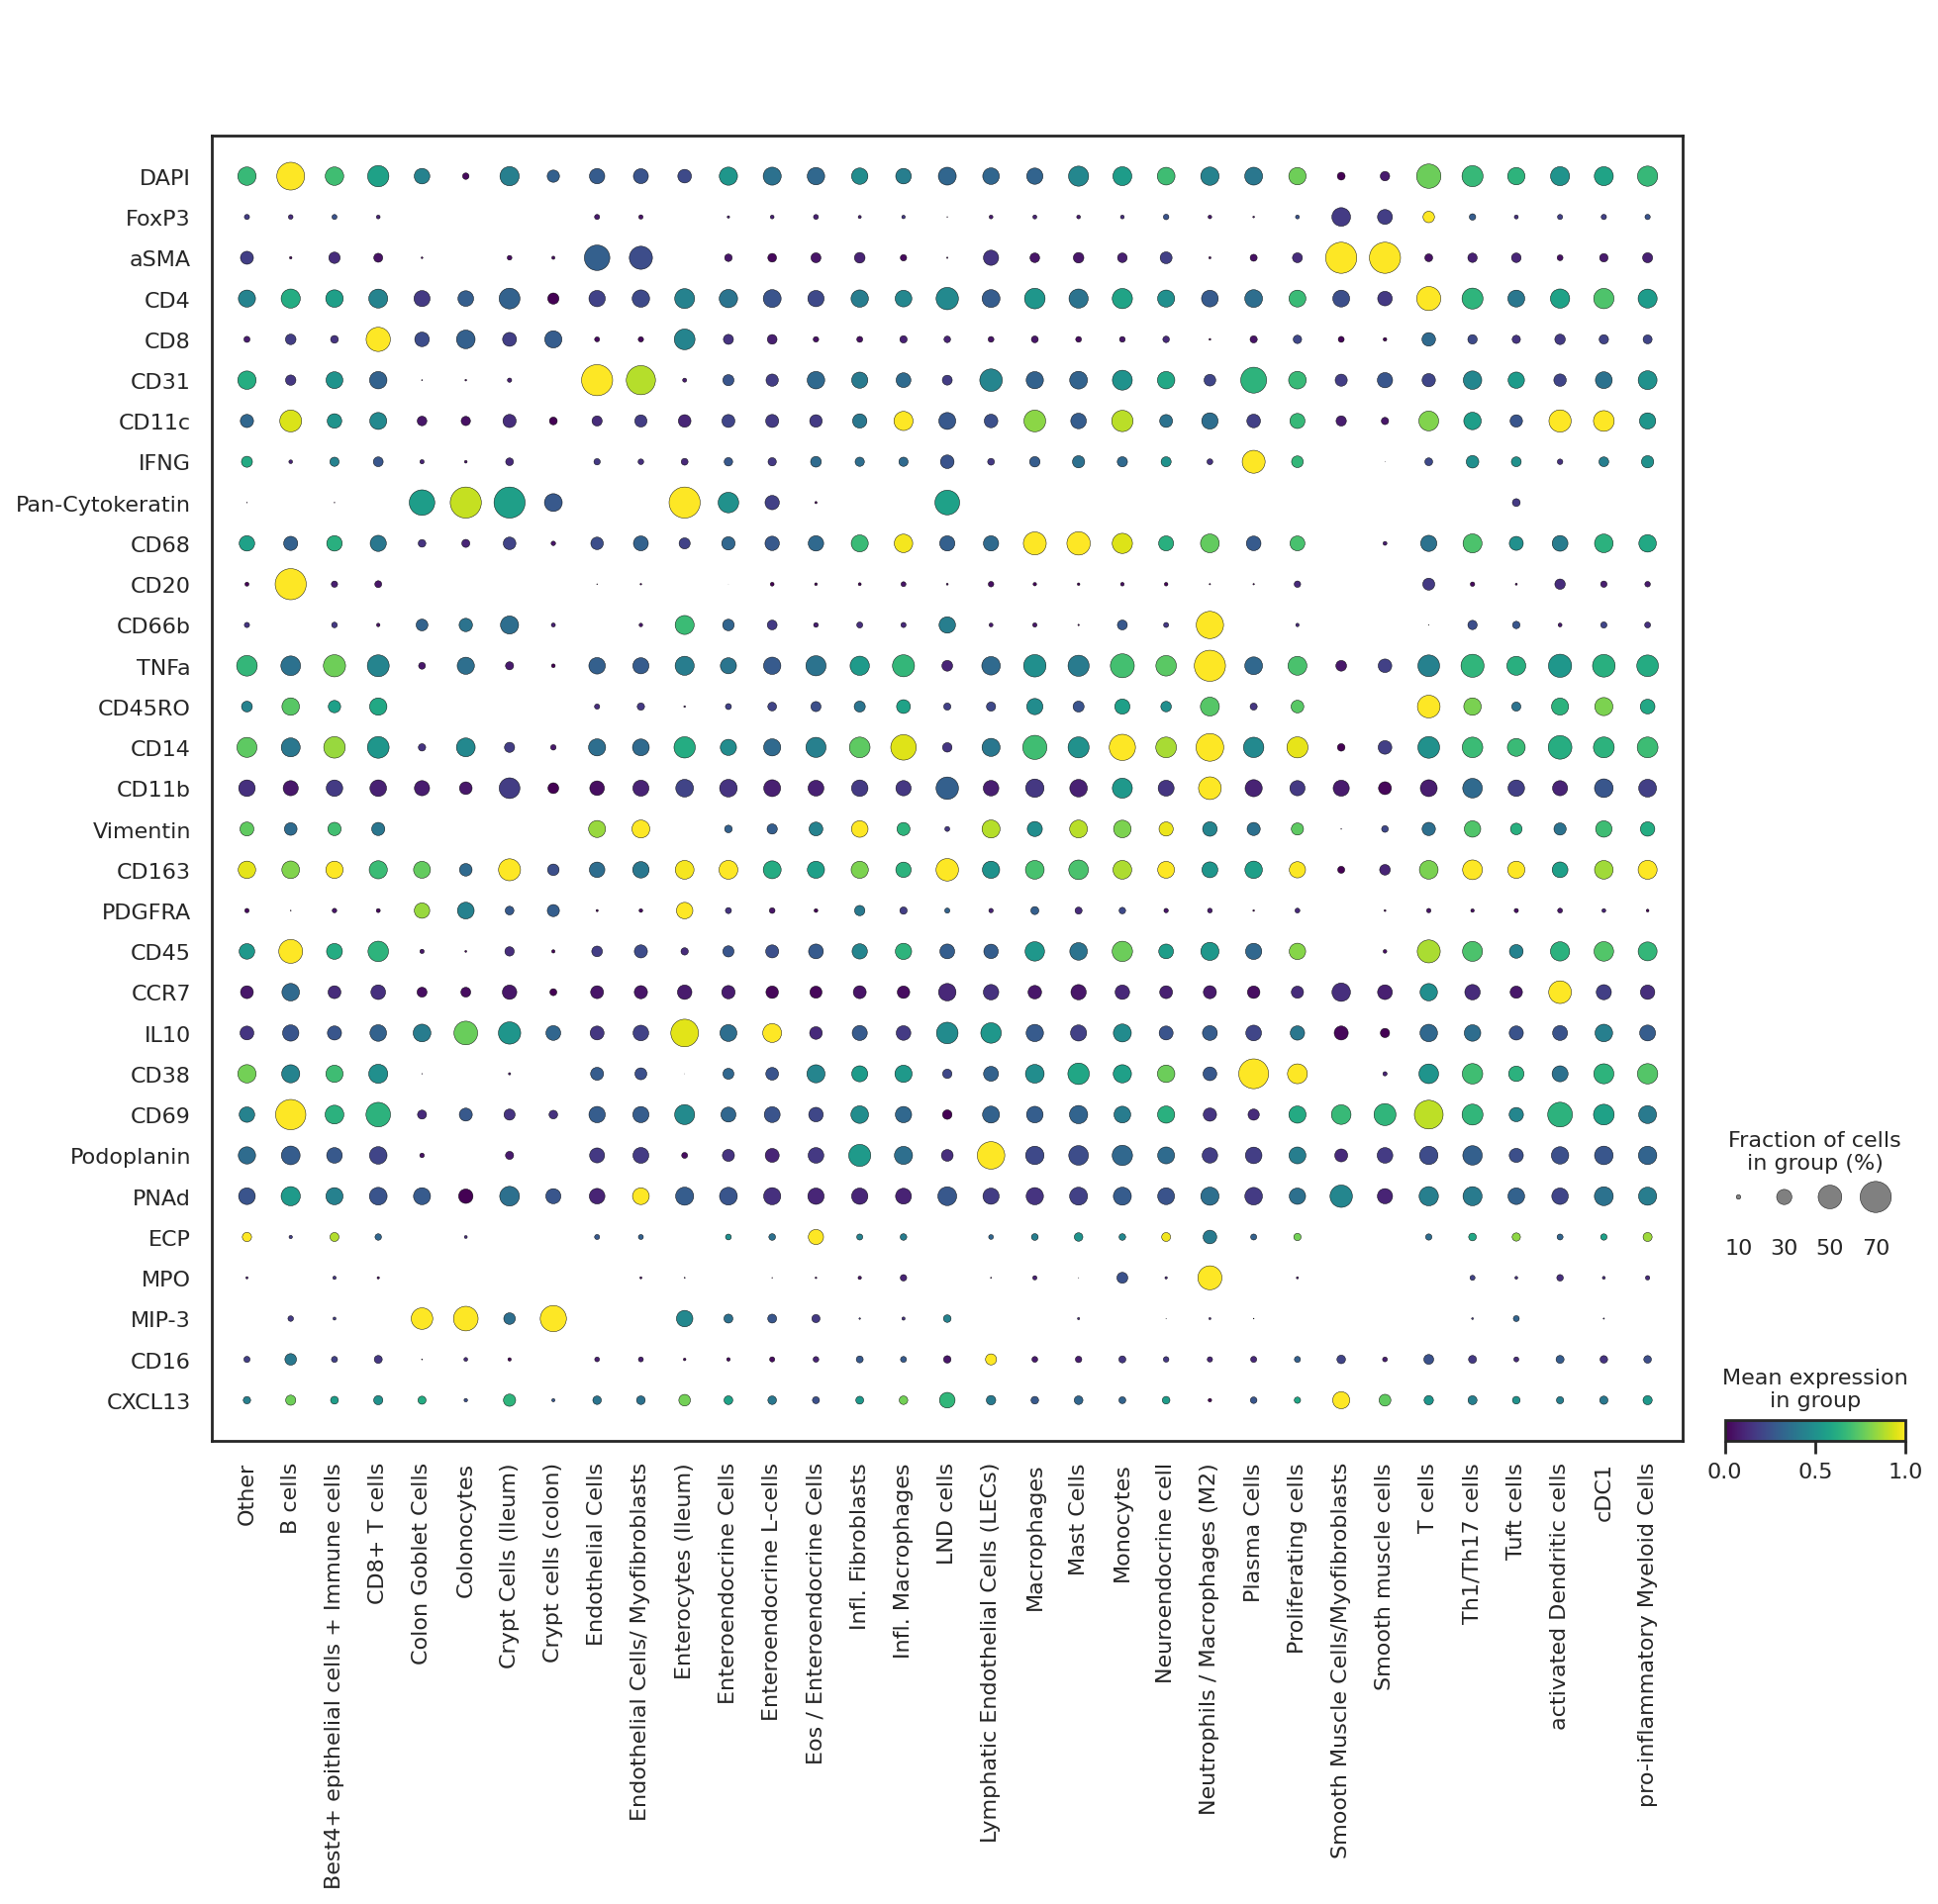

In [100]:
sns.set_style("white")
# 2. Create a temporary AnnData with only those markers 
codex_expr = ad.AnnData( X=adata.obs[codex_channels].values, obs=pd.DataFrame({"cluster": adata.obs['xenium_annotation'].values}), var=pd.DataFrame(index=codex_channels) ) 
# 3. Dotplot per cluster 
sc.pl.dotplot( codex_expr, var_names=codex_channels, groupby="cluster", standard_scale="var", # scales each marker across clusters 
              cmap="viridis", dot_max=0.7, dot_min=0.05, swap_axes=True, save="_codex_markers_per_xenium_cluster_highres.png" )

## With new annotation 

In [36]:
full_adata = ad.read_h5ad("/media/Lynn/data/Integrated_data/adata/run2_3_codex_znorm_xenium_norm100_log_scale_16_umap_leiden_0_7.h5ad")

In [70]:
# Replace '??' with 'Other' in xenium_annotation
full_adata.obs["xenium_annotation"] = full_adata.obs["xenium_annotation"].replace("??", "Other")

adata= full_adata.copy()

In [101]:
import pandas as pd

# 1. Read the new annotation CSV
new_ann = pd.read_csv("/media/Lynn/data/run_2_3_final_annotation.csv")

# Check the columns
print(new_ann.columns)

# Make sure there is a 'cell_id' column and a column with the annotation (e.g., 'annotation')
# Adjust column name below if different
cell_id_col = "cell_id"
annotation_col = "annotation"

# 2. Create a mapping from cell_id -> new annotation
cell_to_annotation = dict(zip(new_ann[cell_id_col], new_ann[annotation_col]))

# 3. Map to adata.obs
adata.obs['joint_annotation'] = adata.obs_names.map(cell_to_annotation)

# 4. Optional: check how many cells got matched
print(f"Number of cells with new annotation: {adata.obs['joint_annotation'].notna().sum()} / {adata.n_obs}")

adata.obs["joint_annotation"] = adata.obs["joint_annotation"].replace("Transit Amplifying Cells (Ileum)", "Other")
adata.obs["joint_annotation"] = adata.obs["joint_annotation"].replace("M-Cells (?)", "M-Cells")


Index(['cell_id', 'annotation'], dtype='object')
Number of cells with new annotation: 2205205 / 2205205


In [102]:
#--------------------------------------------------
# 1. Define protein → gene mapping (from your table)
#--------------------------------------------------
protein_to_gene = {
    "FoxP3": "FOXP3",
    "aSMA": "ACTA2",
    "CD4": "CD4",
    "CD8": "CD8A",      # use CD8A (or average CD8A/B if desired)
    "CD11c": "ITGAX",
    "IFNG": "IFNG",
    "CD68": "CD68",
    "CD20": "MS4A1",
    "TNFa": "TNF",
    "CD14": "CD14",
    "CD11b": "ITGAM",
    "CD163": "CD163",
    "IL10": "IL10",
    "CD45": "PTPRC",
    "CCR7": "CCR7",
    "PDGFRA": "PDGFRA",
    "Podoplanin": "PDPN",
    "MIP-3": "CCL20",
}
print(f"Matched {len(protein_to_gene)} protein–transcript pairs.")

#--------------------------------------------------
# 2. Select relevant columns from your AnnData
#--------------------------------------------------
protein_cols = list(protein_to_gene.keys())
transcript_cols = [g for g in protein_to_gene.values() if g in adata.var_names]

#--------------------------------------------------
# 3. Extract protein and transcript data
#--------------------------------------------------
# a) Protein data from adata.obs
protein_expr = adata.obs[protein_cols].copy()
protein_expr.columns = [f"{m}_CDX" for m in protein_cols]  # add suffix to avoid duplicates

# b) Transcript data from adata.X
transcript_expr = pd.DataFrame(
    adata[:, transcript_cols].X.toarray() if hasattr(adata.X, "toarray") else adata[:, transcript_cols].X,
    columns=transcript_cols,
    index=adata.obs_names
)

#--------------------------------------------------
# 4. Combine into a single dataframe
#--------------------------------------------------
combined_df = pd.concat([protein_expr, transcript_expr], axis=1)

#--------------------------------------------------
# 5. Order columns so each protein is followed by its transcript
#--------------------------------------------------
ordered_vars = []
for prot, gene in protein_to_gene.items():
    prot_name = f"{prot}_CDX"
    if prot_name in combined_df.columns:
        ordered_vars.append(prot_name)
    if gene in combined_df.columns:
        ordered_vars.append(gene)

# Restrict to existing ordered columns
ordered_vars = [v for v in ordered_vars if v in combined_df.columns]
combined_df = combined_df[ordered_vars]

#--------------------------------------------------
# 6. Create a temporary AnnData for plotting
#--------------------------------------------------
combined_adata = ad.AnnData(
    X=combined_df.values,
    obs=pd.DataFrame({"cluster": adata.obs['joint_annotation'].values}, index=adata.obs_names),
    var=pd.DataFrame(index=combined_df.columns)
)

Matched 18 protein–transcript pairs.


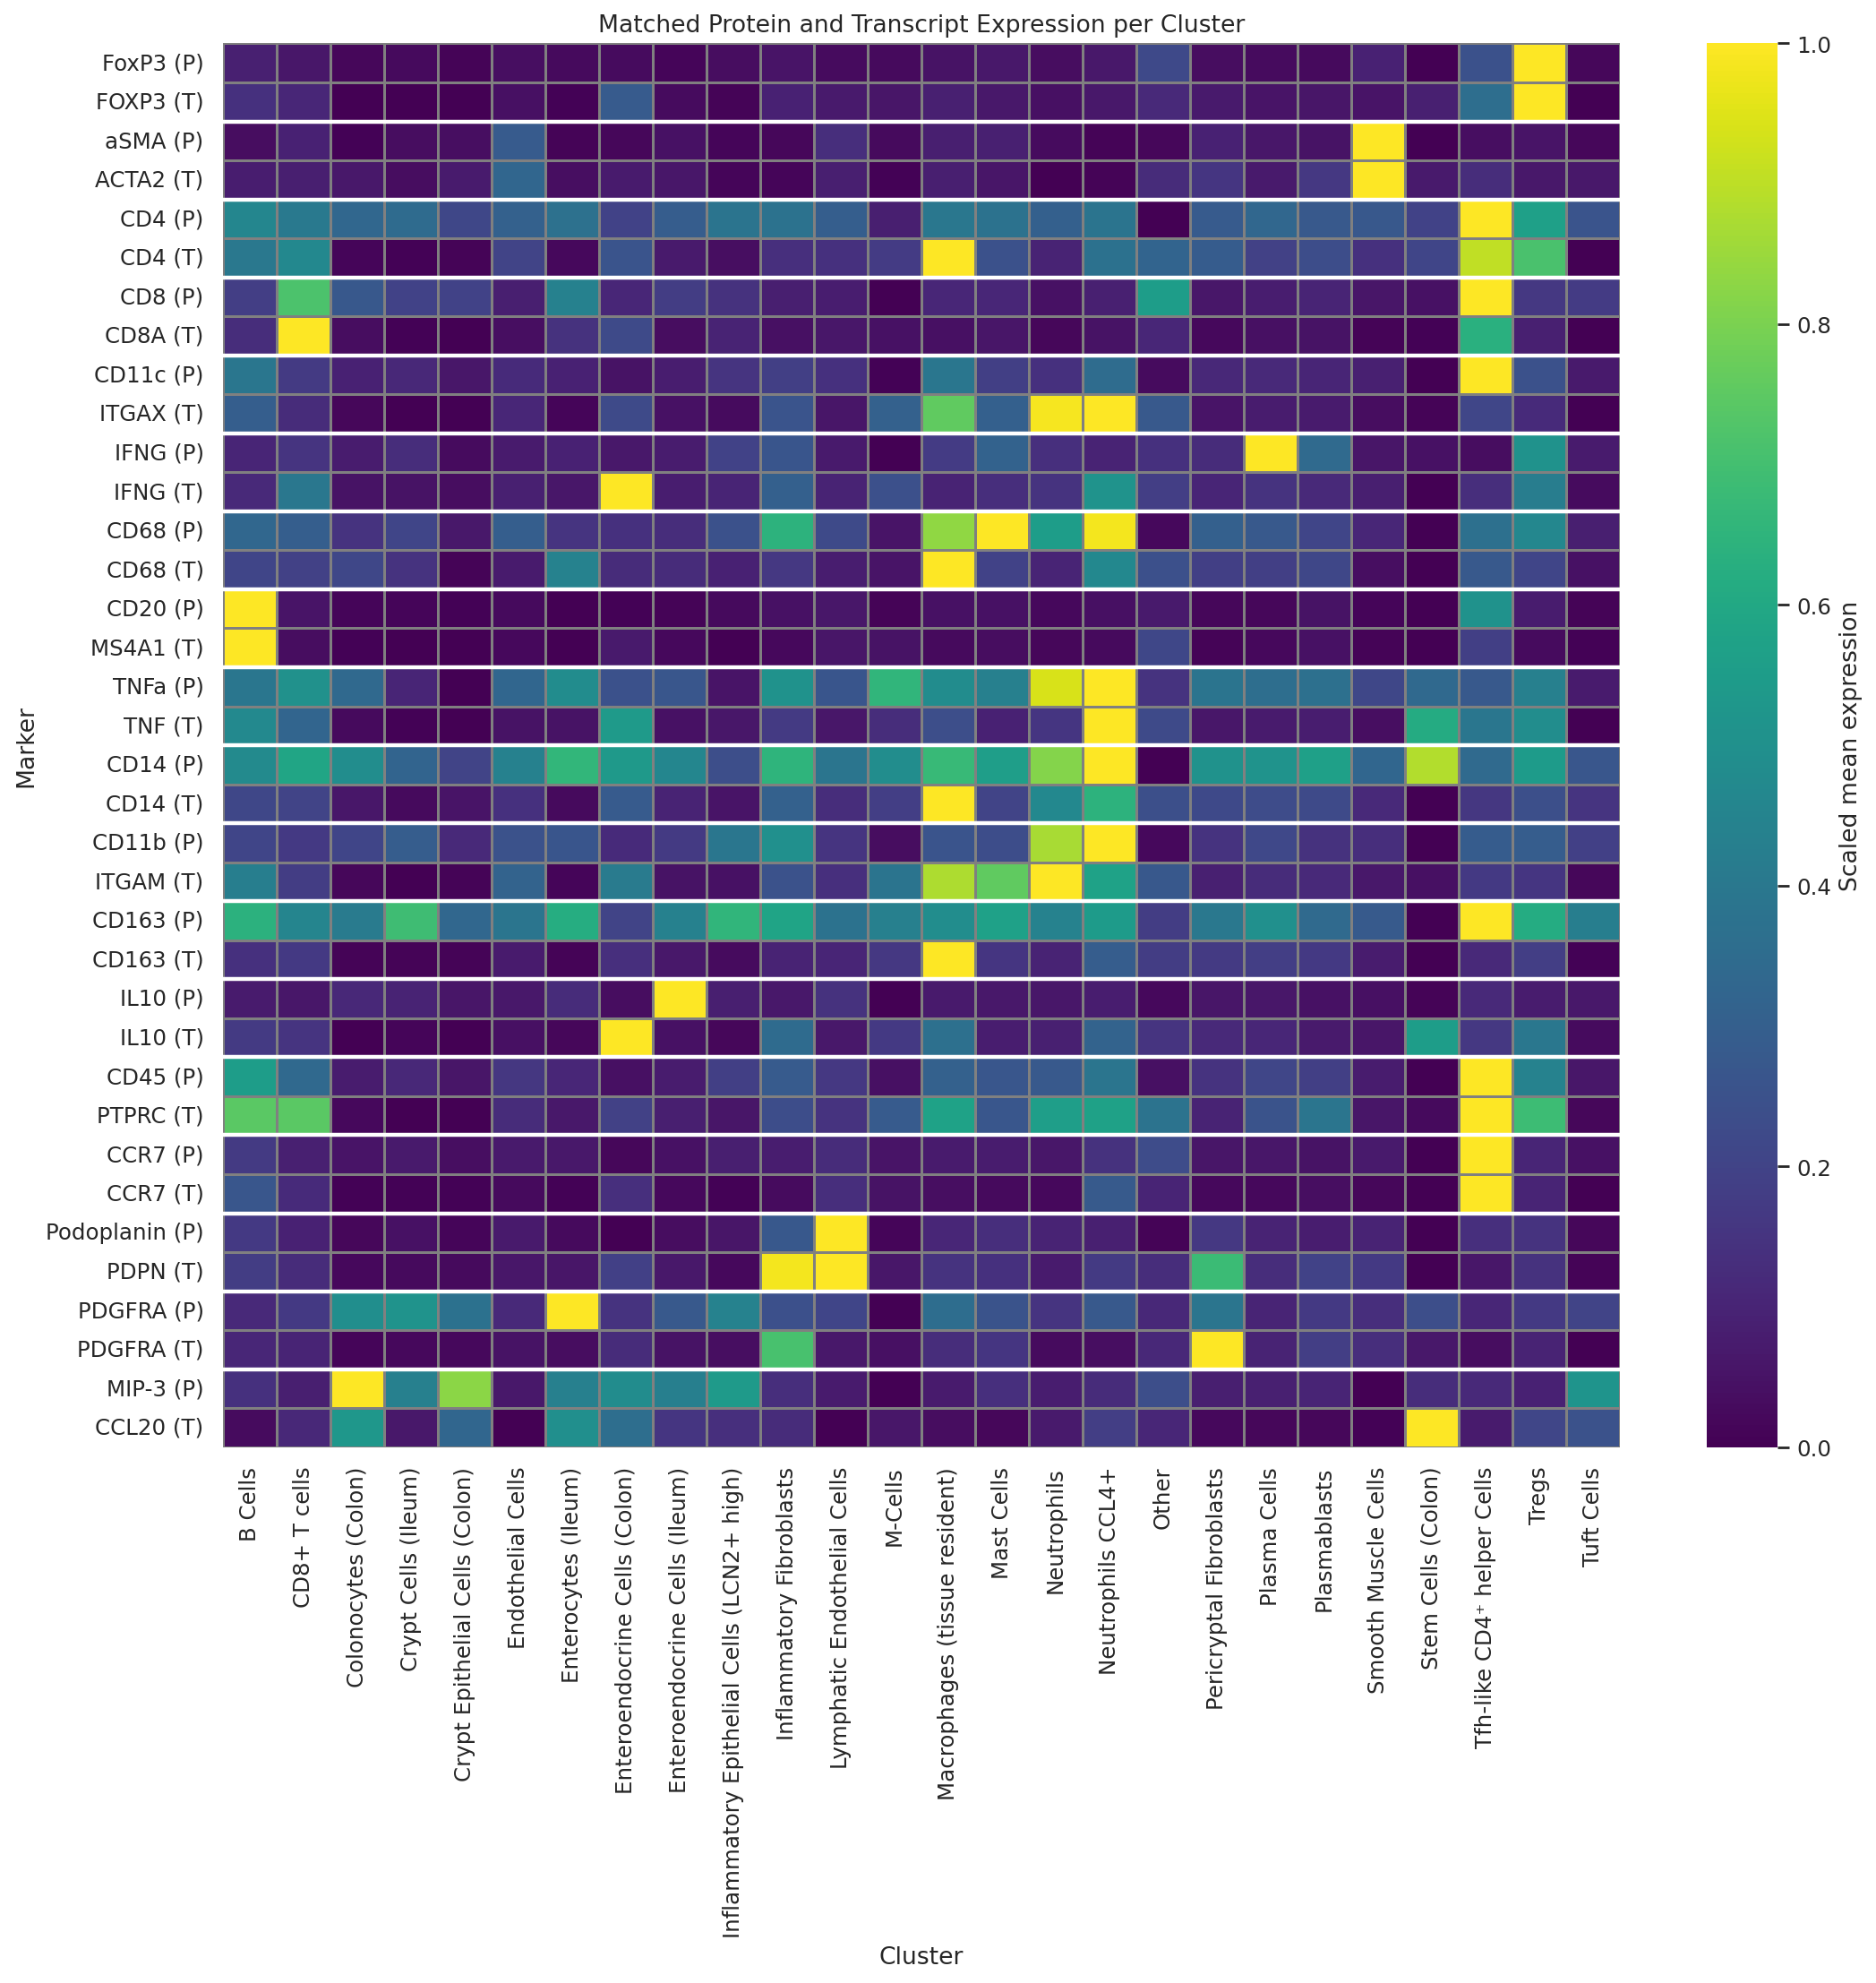

In [103]:
# 1. Matched protein–transcript pairs
pairs = [
    ("FoxP3_CDX", "FOXP3"),
    ("aSMA_CDX", "ACTA2"),
    ("CD4_CDX", "CD4"),
    ("CD8_CDX", "CD8A"),
    ("CD11c_CDX", "ITGAX"),
    ("IFNG_CDX", "IFNG"),
    ("CD68_CDX", "CD68"),
    ("CD20_CDX", "MS4A1"),
    ("TNFa_CDX", "TNF"),
    ("CD14_CDX", "CD14"),
    ("CD11b_CDX", "ITGAM"),
    ("CD163_CDX", "CD163"),
    ("IL10_CDX", "IL10"),
    ("CD45_CDX", "PTPRC"),
    ("CCR7_CDX", "CCR7"),
    ("Podoplanin_CDX", "PDPN"),
    ("PDGFRA_CDX", "PDGFRA"),
    ("MIP-3_CDX", "CCL20"),
]

# Keep only pairs present in your data
pairs = [(p, r) for p, r in pairs if p in combined_adata.var_names and r in combined_adata.var_names]

# 2. Mean expression per cluster
cluster_key = "cluster"
df = pd.DataFrame(combined_adata.X, columns=combined_adata.var_names, index=combined_adata.obs[cluster_key])
mean_expr = df.groupby(level=0).mean()

# 3. Order columns according to pairs
ordered_cols = [x for pair in pairs for x in pair]
mean_expr = mean_expr[ordered_cols]

# Scale 0–1 per marker
scaled = (mean_expr - mean_expr.min()) / (mean_expr.max() - mean_expr.min())

# 4. Plot heatmap
plt.figure(figsize=(14, 14))
sns.set_style("white")
ax = sns.heatmap(
    scaled.T,
    cmap="viridis",
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"label": "Scaled mean expression"},
)

# 5. Add separators **between each protein–RNA pair**
for i in range(1, len(pairs)):
    ax.hlines(y=i*2, xmin=0, xmax=scaled.shape[0], colors="white", linewidth=2)

# 6. Add y-axis labels (protein + RNA)
yticklabels = []
for p, r in pairs:
    yticklabels.append(p.replace("_CDX", "") + " (P)")
    yticklabels.append(r + " (T)")

yticks = np.arange(len(ordered_cols)) + 0.5
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels, rotation=0)

# Labels and title
plt.ylabel("Marker")
plt.xlabel("Cluster")
plt.title("Matched Protein and Transcript Expression per Cluster")

plt.tight_layout()
plt.savefig("joint_heatmap_protein_transcript_pairs_separated_highres.png", dpi=500)
plt.show()


/scratch/lyarab/micromamba/envs/spatialdata-fixed/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


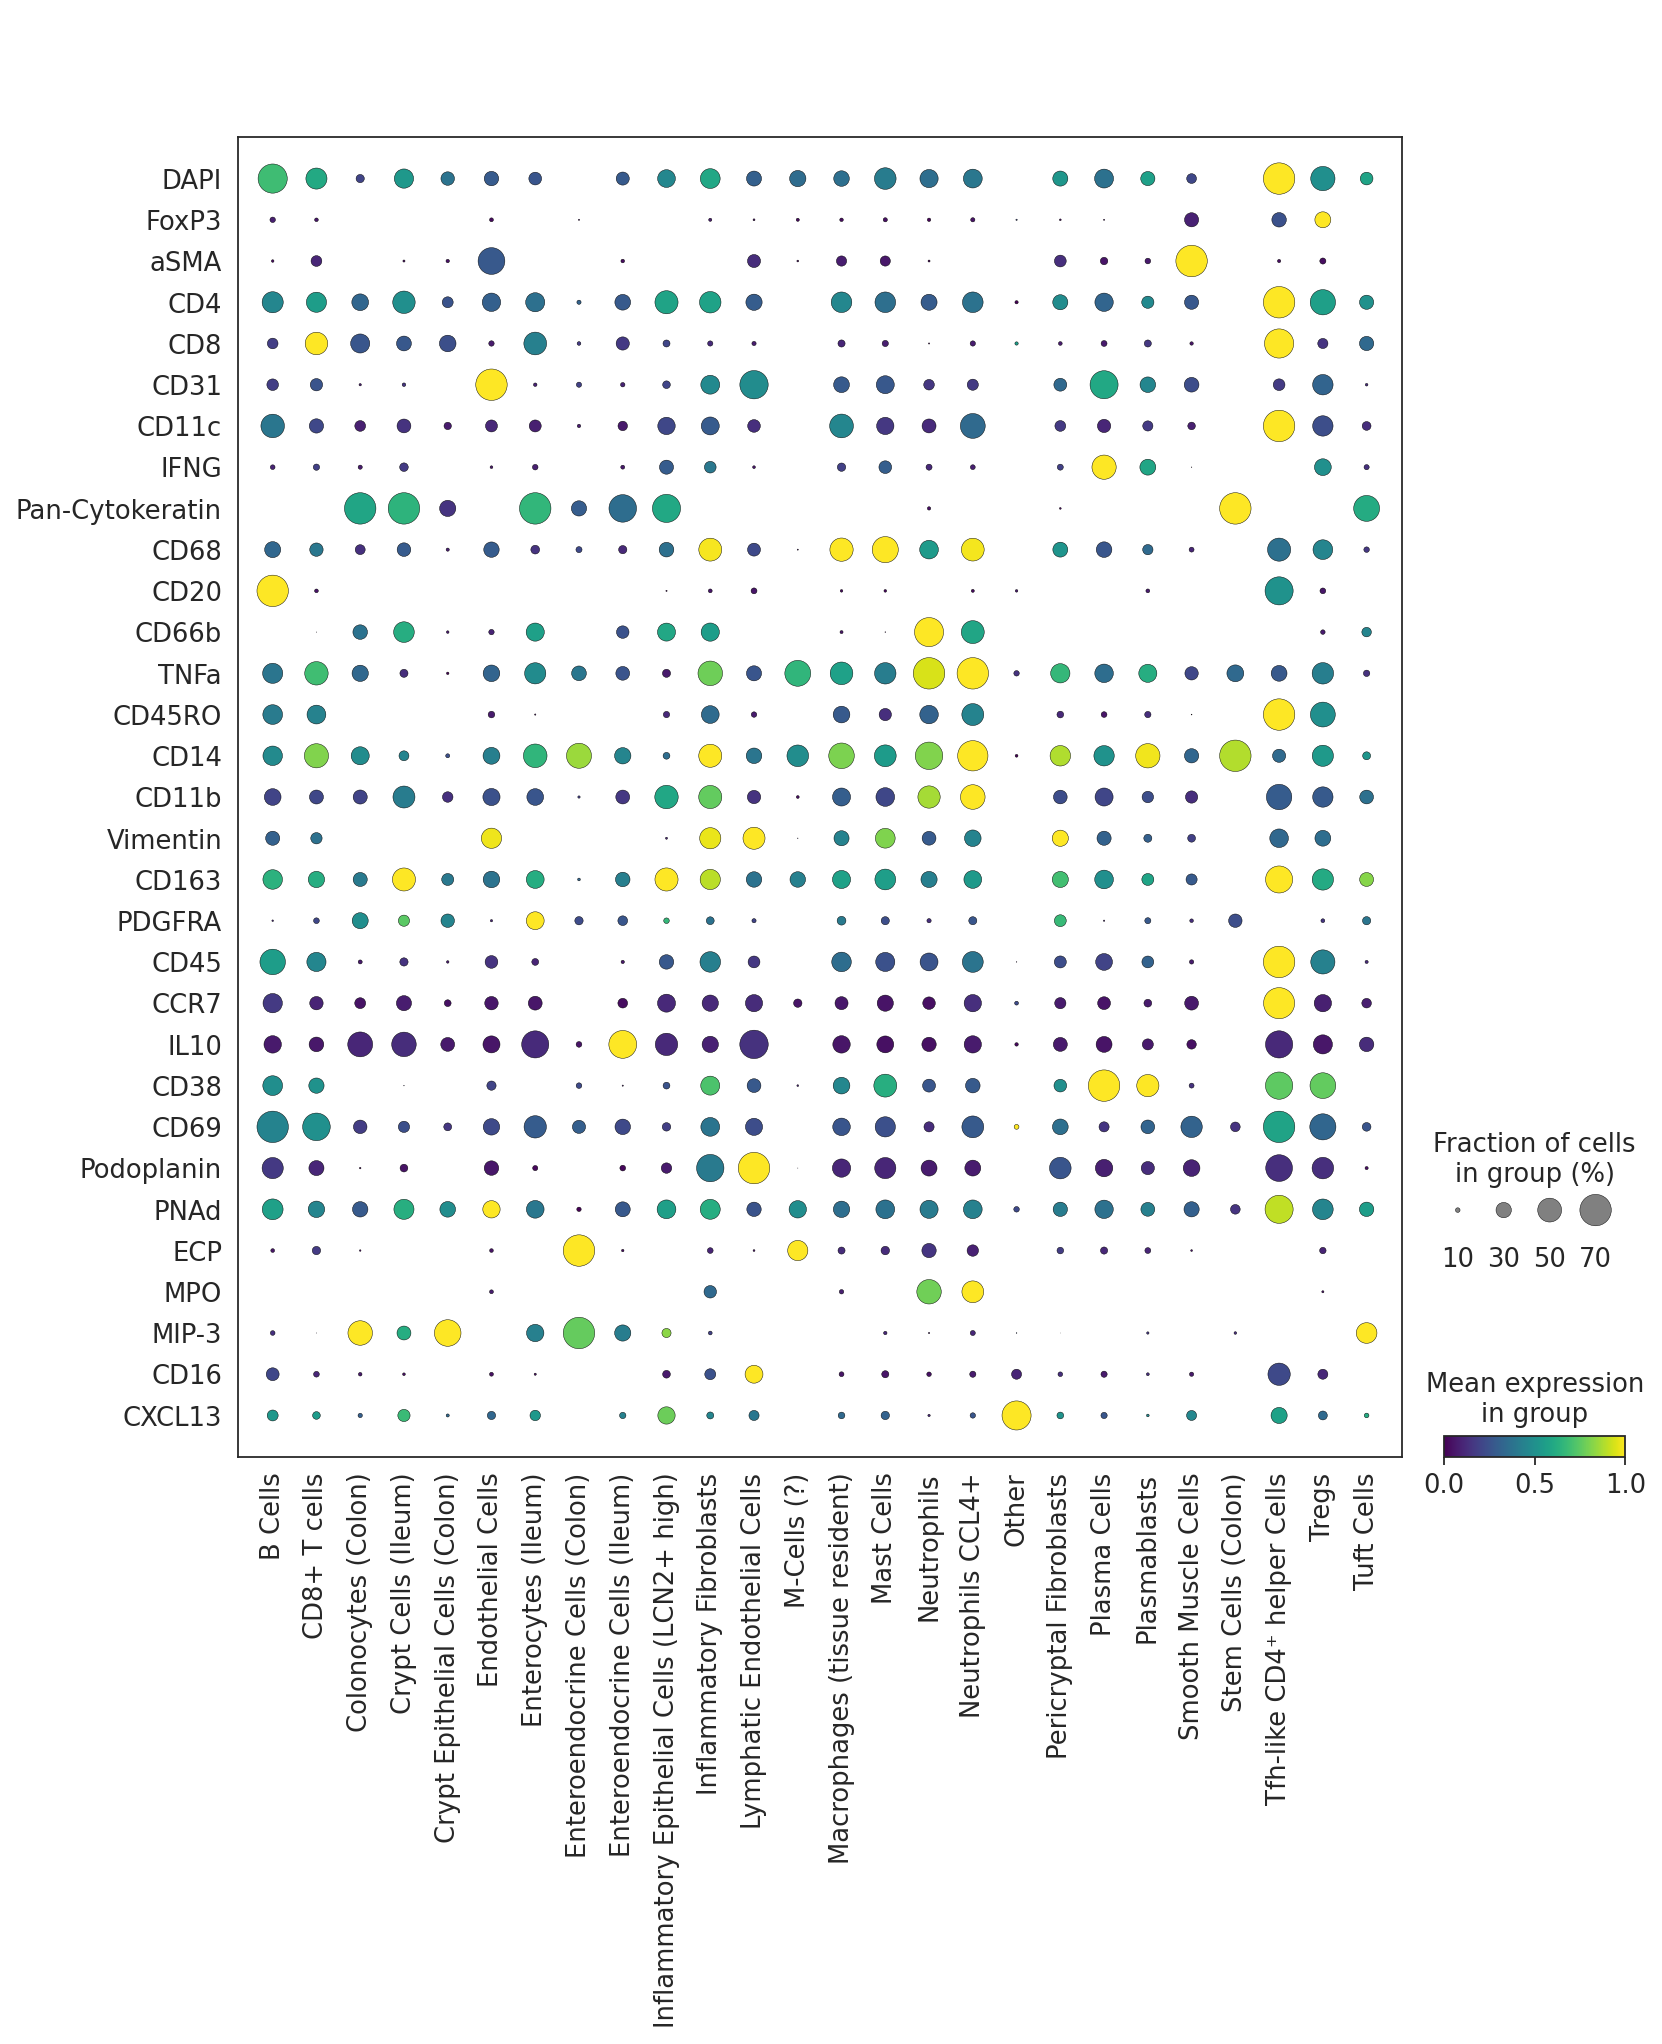

In [77]:
# 2. Create a temporary AnnData with only those markers 
codex_expr = ad.AnnData( X=adata.obs[codex_channels].values, obs=pd.DataFrame({"cluster": adata.obs['joint_annotation'].values}), var=pd.DataFrame(index=codex_channels) ) 
# 3. Dotplot per cluster 
sc.pl.dotplot( codex_expr, var_names=codex_channels, groupby="cluster", standard_scale="var", # scales each marker across clusters 
              cmap="viridis", dot_max=0.7, dot_min=0.05, swap_axes=True, save="_codex_markers_per_joint_cluster_highres.png" )

## How many cells changed annotation

In [104]:
df = adata.obs[['xenium_annotation', 'joint_annotation']].copy()
df = df.dropna()
pairs = df.groupby(['xenium_annotation', 'joint_annotation'], observed=False).size().reset_index(name='count')
print(pairs)


                  xenium_annotation                joint_annotation  count
0                             Other                         B Cells    412
1                             Other                    CD8+ T cells    525
2                             Other             Colonocytes (Colon)     14
3                             Other             Crypt Cells (Ileum)     89
4                             Other  Crypt Epithelial Cells (Colon)     52
..                              ...                             ...    ...
853  pro-inflammatory Myeloid Cells             Smooth Muscle Cells    482
854  pro-inflammatory Myeloid Cells              Stem Cells (Colon)      0
855  pro-inflammatory Myeloid Cells      Tfh-like CD4⁺ helper Cells     97
856  pro-inflammatory Myeloid Cells                           Tregs   1090
857  pro-inflammatory Myeloid Cells                      Tuft Cells      0

[858 rows x 3 columns]


In [105]:
# Define mapping of similar names
rename_map = {
    'Macrophages': 'Macrophages (tissue resident)',
    'Infl. Fibroblasts': 'Inflammatory Fibroblasts',
    'Smooth Muscle Cells/Myofibroblasts': 'Smooth Muscle Cells',
    'Colonocytes': 'Colonocytes (Colon)',
    'Lymphatic Endothelial Cells (LECs)': 'Lymphatic Endothelial Cells',
    'B cells': 'B Cells',
    'LND cells': 'Inflammatory Epithelial Cells (LCN2+ high)'
}

# Apply to both source and target columns
pairs['xenium_annotation'] = pairs['xenium_annotation'].replace(rename_map)
pairs['joint_annotation'] = pairs['joint_annotation'].replace(rename_map)

# Make lowercase copies for comparison
pairs['from_lower'] = pairs['xenium_annotation'].str.lower()
pairs['to_lower'] = pairs['joint_annotation'].str.lower()

# Keep only true changes ignoring case
pairs_df_changed = pairs[pairs['from_lower'] != pairs['to_lower']].copy()


/tmp/ipykernel_21646/1991237161.py:13: FutureWarning:

The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.



In [106]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt

pio.renderers.default = "iframe_connected"

def plot_sankey_clean_no_legend(
    pairs_df,
    from_col="xenium_annotation",
    to_col="joint_annotation",
    min_flow_threshold=1,
    title="Annotation transition",
    alpha=0.6
):
    # 1. Filter
    pairs_df = pairs_df[pairs_df[from_col] != pairs_df[to_col]].copy()
    pairs_df = pairs_df[pairs_df['count'] >= min_flow_threshold]
    if pairs_df.empty:
        raise ValueError("No flows above the min_flow_threshold!")

    # 2. Build labels and ids
    sources, targets, values = [], [], []
    label_map = {}
    label_counter = 0
    def get_label_id(label):
        nonlocal label_counter
        if label not in label_map:
            label_map[label] = label_counter
            label_counter += 1
        return label_map[label]

    for _, row in pairs_df.iterrows():
        src_label = f"{from_col}: {row[from_col]}"
        tgt_label = f"{to_col}: {row[to_col]}"
        sources.append(get_label_id(src_label))
        targets.append(get_label_id(tgt_label))
        values.append(row['count'])

    # 3. Generate colors (~30 distinct)
    all_annotations = sorted(set([row[from_col] for _, row in pairs_df.iterrows()] +
                                 [row[to_col] for _, row in pairs_df.iterrows()]))

    base_colors = list(plt.cm.tab20.colors) + list(plt.cm.tab20b.colors) + list(plt.cm.tab20c.colors)
    base_colors = base_colors[:30]
    color_cycle = [base_colors[i % len(base_colors)] for i in range(len(all_annotations))]
    annotation_color_map = {
        ann: f"rgba({int(r*255)},{int(g*255)},{int(b*255)},{alpha})"
        for ann, (r, g, b) in zip(all_annotations, color_cycle)
    }

    node_colors = [annotation_color_map[label.split(": ")[1]] for label in label_map.keys()]
    link_colors = [annotation_color_map[list(label_map.keys())[list(label_map.values()).index(src_id)].split(": ")[1]] 
                   for src_id in sources]

    # 4. Build Sankey (no legend)
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=list(label_map.keys()),
            color=node_colors
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values,
            color=link_colors
        )
    )])

    # 5. Clean layout (no grid, no axes, no legend)
    fig.update_layout(
        title_text=title,
        font_size=22,
        height=1600,
        width=1400,
        margin=dict(l=50, r=100, t=100, b=50),
        showlegend=False,
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )

    #fig.show()
    return fig



In [107]:
plot_sankey_clean_no_legend(
    pairs_df_changed,
    from_col="xenium_annotation",
    to_col="joint_annotation",
    min_flow_threshold=8000,
    title=" "
)

In [108]:
fig = plot_sankey_clean_no_legend(pairs_df_changed, min_flow_threshold=8000,
    title=" ")

# Save as PNG (high DPI)
fig.write_image("sankey_plot.png", scale=4)  # scale increases resolution

In [23]:
subset = adata.obs[
    (adata.obs['xenium_annotation'] == 'Colon Goblet Cells') &
    (adata.obs['joint_annotation'].isin(['Crypt Cells (ileum)', 'Enterocytes (Ileum)']))
]

# 2. Count the number of cells per slide_ID + core_ID combination
counts = subset.groupby(['slide_ID', 'core_ID']).size().reset_index(name='cell_count')

# 3. Get the combination with the most cells
max_combination = counts.loc[counts['cell_count'].idxmax()]

print(max_combination)

slide_ID      56764
core_ID        X1Y7
cell_count     1088
Name: 70, dtype: object


/tmp/ipykernel_21646/664401551.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [15]:
adata_false_colon_core = adata[(adata.obs['slide_str']=='ID_0056764')&(adata.obs['core_ID']=='X1Y7')&(adata.obs['xenium_annotation']=='Colon Goblet Cells')].copy()

In [16]:
adata_tmp = adata_false_colon_core.copy()
coords = adata_tmp.obsm['spatial']

# Get min and max for x and y
x_min, y_min = np.min(coords, axis=0)
x_max, y_max = np.max(coords, axis=0)

print(f"x_min: {x_min}, x_max: {x_max}")
print(f"y_min: {y_min}, y_max: {y_max}")


x_min: 490.3918151855469, x_max: 2631.75927734375
y_min: 14197.828125, y_max: 16389.765625


In [17]:
size = 1000       # side length of the square
x_offset = 600    # move right from the left edge
y_offset = 600    # move down from the top edge

# Compute crop coordinates
x_min_crop = 407.3 + x_offset
x_max_crop = x_min_crop + size

y_max_crop = 16405 - y_offset
y_min_crop = y_max_crop - size

# Create mask
coords = adata_tmp.obsm['spatial']
mask = (
    (coords[:, 0] >= x_min_crop) & (coords[:, 0] <= x_max_crop) &
    (coords[:, 1] >= y_min_crop) & (coords[:, 1] <= y_max_crop)
)

# Crop AnnData
adata_cropped = adata_tmp[mask].copy()


/tmp/ipykernel_21646/2327215703.py:9: FutureWarning:

Use `squidpy.pl.spatial_scatter` instead.



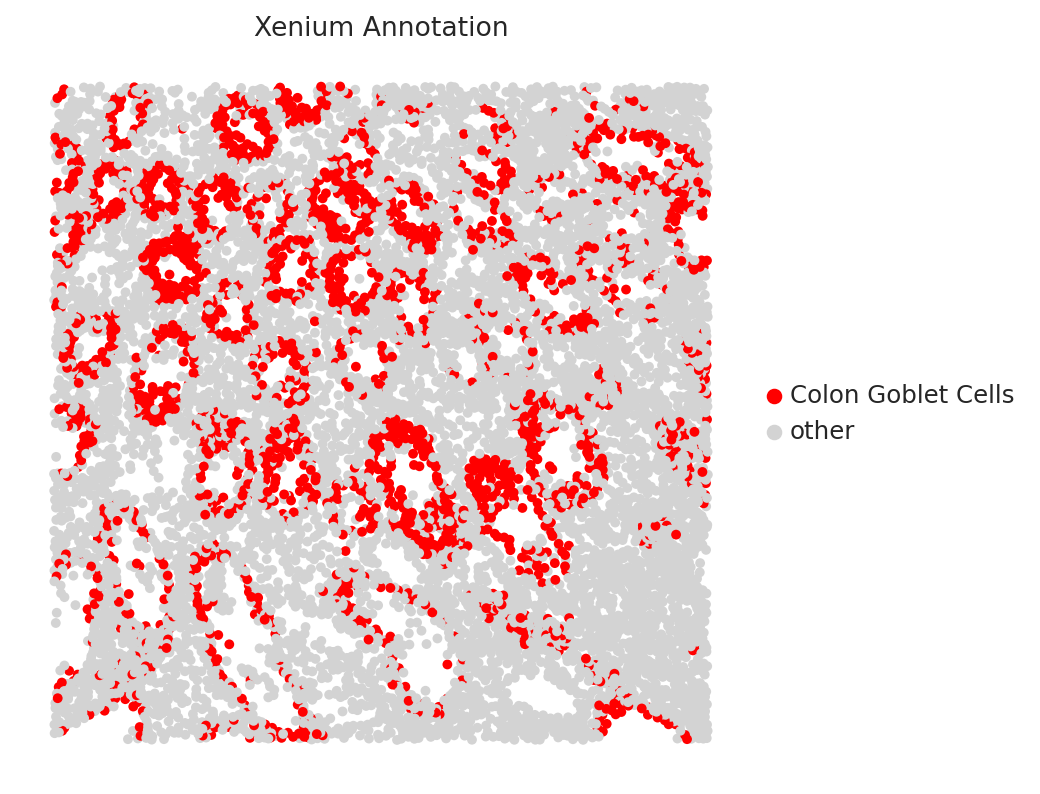

In [71]:
# Replace all cluster labels except '22' with 'other'
adata_cropped.obs['cluster_highlight'] = adata_cropped.obs['xenium_annotation'].astype(str)
adata_cropped.obs['cluster_highlight'] = adata_cropped.obs['cluster_highlight'].where(
    adata_tmp.obs['xenium_annotation'] == 'Colon Goblet Cells',  
    'other'  # replace everything else
)

# Plot with custom palette (grey for "other")
sc.pl.spatial(
    adata_cropped,
    spot_size = 15,
    color='cluster_highlight',
    palette=['red', 'lightgrey'],  # order matches sorted categories
    wspace=0.4,
    title = 'Xenium Annotation',
    save='_cropped_fake_colon_goblet_cells.png'
)

/tmp/ipykernel_1186/3333034930.py:8: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


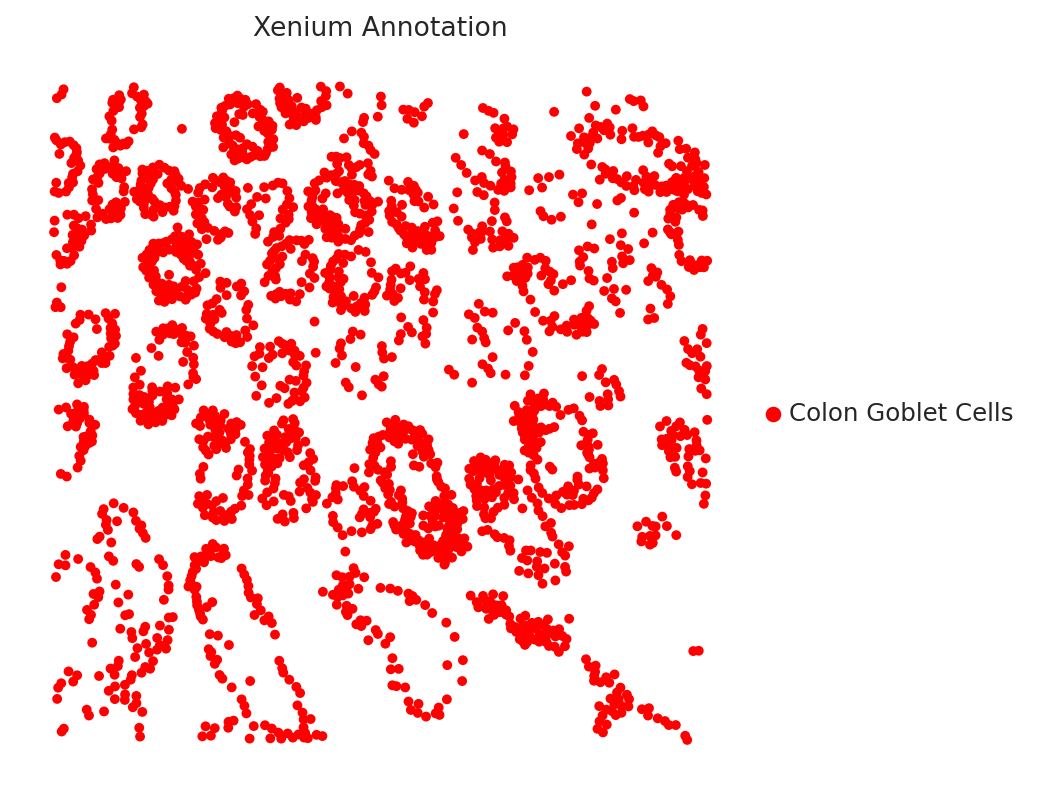

In [20]:
# Replace all cluster labels except '22' with 'other'
adata_cropped.obs['cluster_highlight'] = adata_cropped.obs['xenium_annotation'].astype(str)
adata_cropped.obs['cluster_highlight'] = adata_cropped.obs['cluster_highlight'].where(
    adata_tmp.obs['xenium_annotation'] == 'Colon Goblet Cells'
)

# Plot with custom palette (grey for "other")
sc.pl.spatial(
    adata_cropped,
    spot_size = 15,
    color='cluster_highlight',
    palette=['red'],  # order matches sorted categories
    wspace=0.4,
    title = 'Xenium Annotation',
    save='_NEWcropped_fake_colon_goblet_cells.png'
)

/tmp/ipykernel_21646/400223492.py:22: FutureWarning:

Use `squidpy.pl.spatial_scatter` instead.



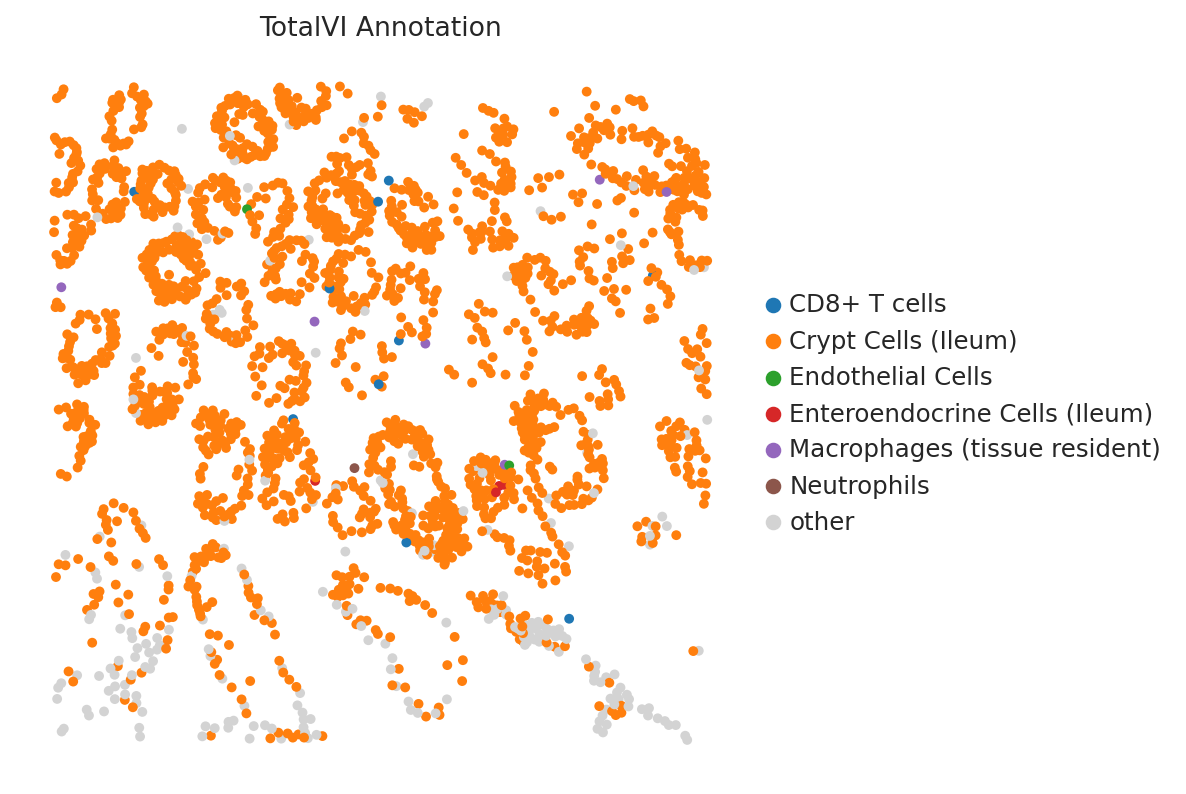

In [70]:
# Specify which annotations you want to highlight
highlight_values = ['CD8+ T cells', 'Crypt Cells (Ileum)', 'Endothelial Cells', 'Enteroendocrine Cells (Ileum)', 'Macrophages (tissue resident)', 'Neutrophils', 'Tregs']  # replace with your actual joint_annotation values

# Create a new column for highlighting
adata_cropped.obs['cluster_highlight'] = adata_cropped.obs['joint_annotation'].astype(str)

# Replace everything not in highlight_values with 'other'
adata_cropped.obs['cluster_highlight'] = adata_cropped.obs['cluster_highlight'].where(
    adata_cropped.obs['cluster_highlight'].isin(highlight_values),
    'other'
)

# Create a color palette: one color per highlight value + grey for 'other'
import seaborn as sns
highlight_colors = sns.color_palette('tab10', n_colors=len(highlight_values))  # you can change palette
palette_dict = {v: c for v, c in zip(highlight_values, highlight_colors)}
palette_dict['other'] = 'lightgrey'

new_adata_tmp = adata_cropped[adata_cropped.obs['xenium_annotation']=='Colon Goblet Cells'].copy()

# Plot
sc.pl.spatial(
    new_adata_tmp,
    spot_size=15,
    color='cluster_highlight',
    palette=palette_dict,
    wspace=0.4,
    title='TotalVI Annotation',
    save='_cropped_corrected_fake_colon_goblet_cells.png'
)